# LGBM을 활용한 베이스라인

In [9]:
import numpy as np
import pandas as pd
import os
import random

## 1. 데이터 로딩

In [10]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

data_dir = '/opt/ml/input/data/' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
train_df = pd.read_csv(csv_file_path, dtype=dtype, parse_dates=['Timestamp']) 

CPU times: user 2.78 s, sys: 160 ms, total: 2.94 s
Wall time: 2.94 s


In [11]:
test_df = pd.read_csv(data_dir+'test_data.csv', dtype=dtype, parse_dates=['Timestamp'])
test_df = test_df[test_df['answerCode']!=-1]

In [12]:
test_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623
...,...,...,...,...,...,...
260108,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244


In [13]:
train_df.sort_values(by=['userID','Timestamp'], inplace=True)

In [14]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


## 2. Feature Engineering

In [15]:
def minsum(s):
    a = np.sort(s)
    if a[0] == 0:
        a[0] = 1
    ans = 0
    length = 0
    
    for i in a:
        if i>a[0]*5:
            break
        ans += i
        length += 1
    return ans / length

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   userID            int16         
 1   assessmentItemID  object        
 2   testId            object        
 3   answerCode        int8          
 4   Timestamp         datetime64[ns]
 5   KnowledgeTag      int16         
dtypes: datetime64[ns](1), int16(2), int8(1), object(2)
memory usage: 80.0+ MB


In [75]:
def feature_engineering(df):
    from sklearn import preprocessing 

    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    # df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    # Tag, test 별 난이도
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'std'])
    correct_t.columns = ["test_mean", 'test_std']
    correct_t['test_level'] = correct_t['test_mean'] *  correct_t['test_std']
    
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'std'])
    correct_k.columns = ["tag_mean",  'tag_std']
    correct_k['tag_level'] = correct_k['tag_mean'] *  correct_k['tag_std']
    
    df['category_2'] = df['assessmentItemID'].str[2].astype(int)
    # correct_c = df.groupby(['category_2'])['answerCode'].agg(['mean', 'std'])
    # correct_c.columns = ["cat_mean",  'cat_std']
    # correct_c['cat_level'] = correct_c['cat_mean'] *  correct_c['cat_std']
    
    df['Timestamp'] = df['Timestamp'].astype(str)
    df['datetime'] = pd.to_datetime(df['Timestamp'],infer_datetime_format=True)
    df['seconds'] = df['datetime'].apply(lambda x: x.timestamp()) 
    diff = df.loc[:,['userID','seconds']].groupby('userID').diff(periods=-1) 
    df['seconds'] = diff['seconds'].apply(abs) 
    
    time_groupyby = df.groupby(['answerCode','assessmentItemID']).agg({'seconds': minsum})
    time_groupyby = time_groupyby.loc[1].sort_values(by='seconds')

    time_groupyby.loc['A050001007'] = 1000
    time_groupyby.columns = ['meanSeconds']
    
    df['month'] = df['Timestamp'].str[5:7].astype(int)
    df['test_paper'] = df['assessmentItemID'].str[4:7].astype(int)
    df['problem_id'] = df['assessmentItemID'].str[-3:].astype(int)

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    # df = pd.merge(df, correct_c, on=['category_2'], how="left")
    df = pd.merge(df, time_groupyby, on=['assessmentItemID'], how='left')
    
    # 결측치 처리
    df = df.fillna(0)
    
    return df

In [76]:
df = feature_engineering(train_df)

In [77]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'user_acc',
       'datetime', 'seconds', 'month', 'category_2', 'test_paper',
       'problem_id', 'test_mean', 'test_std', 'test_level', 'tag_mean',
       'tag_std', 'tag_level', 'meanSeconds'],
      dtype='object')

## 3. Train/Test 데이터 셋 분리

In [78]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.9, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [150]:
# 유저별 분리
train, valid = custom_train_test_split(df)

# 사용할 Feature 설정
FEATS = [
       'KnowledgeTag', 'seconds', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'month', 'category_2', 'test_paper',
       'problem_id', 'test_mean',  'tag_mean', 'test_std', 'tag_std', 'test_level', 'tag_level',
         'meanSeconds'] 
#  'elapsed', 'elapsed_sum',  'cat_mean', 'cat_std', 'cat_level',
# X, y 값 분리'
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_valid = valid['answerCode']
valid = valid.drop(['answerCode'], axis=1)

In [151]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
import xgboost as xgb
import optuna

## 4. 훈련 및 검증

In [154]:
def RF_objective(trial: optuna.trial.Trial):
    dtrain = xgb.DMatrix(train[FEATS], label=y_train)
    dvalid = xgb.DMatrix(valid[FEATS], label=y_valid)
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric':'auc',
        'booster':'gbtree',
        'n_estimators': trial.suggest_int("n_estimators", 100, 1000, step=10),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        
        # 'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
        # "tree_method": 'exact', 'gpu_id': -1,  # CPU 사용시
        
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        # 'subsample': trial.suggest_float('subsample', 0.6, 1.0, 0.05),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 1),
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 5, 20, step=5),
        "learning_rate": trial.suggest_float('learning_rate', 0.0001, 0.5)
        # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500) 추가하면 느려짐.
        
    }

    model = xgb.XGBClassifier(**params, random_state = 42)
    
#     model.fit(
#     X=train[FEATS],
#     y=y_train,
#     eval_set=[(valid[FEATS], y_valid)],
#     verbose=5
# )
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dvalid)
    auc = roc_auc_score(y_valid, preds)

    return auc

In [155]:
RF_study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
RF_study.optimize(RF_objective, n_trials=1000)

[I 2022-11-30 07:16:40,527] A new study created in memory with name: no-name-c8edb8d3-4a74-476f-948f-d852a54d76bf


[07:16:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:16:48,874] Trial 0 finished with value: 0.7122457394172621 and parameters: {'n_estimators': 750, 'max_depth': 9, 'gamma': 0.21727146456025645, 'min_child_weight': 5, 'colsample_bytree': 0.6087050707340604, 'colsample_bylevel': 0.7310654673420705, 'colsample_bynode': 0.6995231985767594, 'reg_lambda': 0.5454794649554483, 'reg_alpha': 0.629835568706505, 'learning_rate': 0.33151820462072706}. Best is trial 0 with value: 0.7122457394172621.


[07:16:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:16:55,172] Trial 1 finished with value: 0.7021715228147334 and parameters: {'n_estimators': 570, 'max_depth': 7, 'gamma': 0.7993438568644843, 'min_child_weight': 1, 'colsample_bytree': 0.5936354520277001, 'colsample_bylevel': 0.7460625635102225, 'colsample_bynode': 0.7890419974606094, 'reg_lambda': 0.3232897390291214, 'reg_alpha': 0.8012325674164219, 'learning_rate': 0.005720927322314251}. Best is trial 0 with value: 0.7122457394172621.


[07:16:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:17:01,570] Trial 2 finished with value: 0.7103032801905809 and parameters: {'n_estimators': 220, 'max_depth': 7, 'gamma': 0.5991028957591729, 'min_child_weight': 4, 'colsample_bytree': 0.9681543556229066, 'colsample_bylevel': 0.6298470599274825, 'colsample_bynode': 0.5083335177738465, 'reg_lambda': 0.91972087640238, 'reg_alpha': 0.6296853542322488, 'learning_rate': 0.26574052498894557}. Best is trial 0 with value: 0.7122457394172621.


[07:17:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:17:07,001] Trial 3 finished with value: 0.7122411581455013 and parameters: {'n_estimators': 470, 'max_depth': 5, 'gamma': 0.43726918454163793, 'min_child_weight': 4, 'colsample_bytree': 0.7196077781248383, 'colsample_bylevel': 0.6581266766659524, 'colsample_bynode': 0.8730276981419274, 'reg_lambda': 0.2257269124588834, 'reg_alpha': 0.15181174745450415, 'learning_rate': 0.3982176344143364}. Best is trial 0 with value: 0.7122457394172621.


[07:17:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:17:14,770] Trial 4 finished with value: 0.7233828110683526 and parameters: {'n_estimators': 600, 'max_depth': 9, 'gamma': 0.9254747325890788, 'min_child_weight': 3, 'colsample_bytree': 0.7361746941212965, 'colsample_bylevel': 0.541173788298377, 'colsample_bynode': 0.6343754895191488, 'reg_lambda': 0.37107344698033545, 'reg_alpha': 0.6897173433184882, 'learning_rate': 0.19579955524797987}. Best is trial 4 with value: 0.7233828110683526.


[07:17:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:17:20,930] Trial 5 finished with value: 0.6977047828477185 and parameters: {'n_estimators': 730, 'max_depth': 6, 'gamma': 0.2248344167242264, 'min_child_weight': 3, 'colsample_bytree': 0.9043402925756934, 'colsample_bylevel': 0.9669185278598939, 'colsample_bynode': 0.6251179094307284, 'reg_lambda': 0.07532157860728503, 'reg_alpha': 0.5246761052129332, 'learning_rate': 0.36411203093866606}. Best is trial 4 with value: 0.7233828110683526.


[07:17:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:17:25,326] Trial 6 finished with value: 0.7021761040864944 and parameters: {'n_estimators': 450, 'max_depth': 4, 'gamma': 0.10525842244499949, 'min_child_weight': 5, 'colsample_bytree': 0.8534073470206787, 'colsample_bylevel': 0.8641236866402124, 'colsample_bynode': 0.6304956396785683, 'reg_lambda': 0.8082158394769714, 'reg_alpha': 0.9035843048800406, 'learning_rate': 0.23892677629947262}. Best is trial 4 with value: 0.7233828110683526.


[07:17:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:17:33,100] Trial 7 finished with value: 0.7250733003481766 and parameters: {'n_estimators': 380, 'max_depth': 9, 'gamma': 0.3969756065838893, 'min_child_weight': 4, 'colsample_bytree': 0.5121464571427335, 'colsample_bylevel': 0.6561196582896829, 'colsample_bynode': 0.6882198859819747, 'reg_lambda': 0.35362982049889874, 'reg_alpha': 0.22676842142799147, 'learning_rate': 0.127340718832373}. Best is trial 7 with value: 0.7250733003481766.


[07:17:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:17:40,446] Trial 8 finished with value: 0.7182517866959868 and parameters: {'n_estimators': 360, 'max_depth': 7, 'gamma': 0.24494937478006157, 'min_child_weight': 3, 'colsample_bytree': 0.9306692872162383, 'colsample_bylevel': 0.7626799775900535, 'colsample_bynode': 0.8500814298789572, 'reg_lambda': 0.13817243331556167, 'reg_alpha': 0.8721247877846228, 'learning_rate': 0.28356380607403264}. Best is trial 7 with value: 0.7250733003481766.


[07:17:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:17:49,523] Trial 9 finished with value: 0.7270340846619021 and parameters: {'n_estimators': 620, 'max_depth': 9, 'gamma': 0.20612002697434784, 'min_child_weight': 1, 'colsample_bytree': 0.6925841788334592, 'colsample_bylevel': 0.8729509251084571, 'colsample_bynode': 0.7550360846167148, 'reg_lambda': 0.5336234381608284, 'reg_alpha': 0.6298928855374579, 'learning_rate': 0.13049583219107025}. Best is trial 9 with value: 0.7270340846619021.


[07:17:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:18:02,843] Trial 10 finished with value: 0.7406038116181051 and parameters: {'n_estimators': 970, 'max_depth': 10, 'gamma': 0.1209308806666969, 'min_child_weight': 1, 'colsample_bytree': 0.8190591791667746, 'colsample_bylevel': 0.9992370385427979, 'colsample_bynode': 0.9823260570873182, 'reg_lambda': 0.6302261978922595, 'reg_alpha': 0.35620858962074603, 'learning_rate': 0.07133391014652019}. Best is trial 10 with value: 0.7406038116181051.


[07:18:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:18:15,834] Trial 11 finished with value: 0.7305570826461426 and parameters: {'n_estimators': 980, 'max_depth': 10, 'gamma': 0.12248866068030953, 'min_child_weight': 1, 'colsample_bytree': 0.8077098149075232, 'colsample_bylevel': 0.991989187124943, 'colsample_bynode': 0.9964926209042028, 'reg_lambda': 0.6367781327560711, 'reg_alpha': 0.34163773839344064, 'learning_rate': 0.07155051303608671}. Best is trial 10 with value: 0.7406038116181051.


[07:18:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:18:28,658] Trial 12 finished with value: 0.7264156129741616 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'gamma': 0.10175167167464239, 'min_child_weight': 2, 'colsample_bytree': 0.8066006330433366, 'colsample_bylevel': 0.9834034330375486, 'colsample_bynode': 0.9701695410414629, 'reg_lambda': 0.7385126931031362, 'reg_alpha': 0.3324862730701897, 'learning_rate': 0.005014663257909904}. Best is trial 10 with value: 0.7406038116181051.


[07:18:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:18:41,384] Trial 13 finished with value: 0.7314458493677846 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'gamma': 0.14690020462720352, 'min_child_weight': 2, 'colsample_bytree': 0.8173047658617962, 'colsample_bylevel': 0.8946035684907929, 'colsample_bynode': 0.9962639007024261, 'reg_lambda': 0.6803929995897515, 'reg_alpha': 0.38443868337544734, 'learning_rate': 0.48053656838951886}. Best is trial 10 with value: 0.7406038116181051.


[07:18:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:18:54,048] Trial 14 finished with value: 0.7207760674363204 and parameters: {'n_estimators': 870, 'max_depth': 10, 'gamma': 0.1571781474739553, 'min_child_weight': 2, 'colsample_bytree': 0.8588925723965605, 'colsample_bylevel': 0.8927276720335983, 'colsample_bynode': 0.9267134368482725, 'reg_lambda': 0.9686904328938782, 'reg_alpha': 0.37723588545690584, 'learning_rate': 0.4898059566670648}. Best is trial 10 with value: 0.7406038116181051.


[07:18:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:19:04,361] Trial 15 finished with value: 0.7364944108484515 and parameters: {'n_estimators': 850, 'max_depth': 8, 'gamma': 0.16382759896366578, 'min_child_weight': 2, 'colsample_bytree': 0.7924084868482061, 'colsample_bylevel': 0.9215073668642221, 'colsample_bynode': 0.9145421535051308, 'reg_lambda': 0.6767325495982203, 'reg_alpha': 0.4520928318895753, 'learning_rate': 0.4802560392862807}. Best is trial 10 with value: 0.7406038116181051.


[07:19:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:19:12,783] Trial 16 finished with value: 0.7220313358988455 and parameters: {'n_estimators': 840, 'max_depth': 8, 'gamma': 0.16185064413089448, 'min_child_weight': 2, 'colsample_bytree': 0.6733997325495591, 'colsample_bylevel': 0.827134831255867, 'colsample_bynode': 0.8978748055655751, 'reg_lambda': 0.8660380242434573, 'reg_alpha': 0.06179625978679992, 'learning_rate': 0.4398117815072781}. Best is trial 10 with value: 0.7406038116181051.


[07:19:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:19:23,118] Trial 17 finished with value: 0.7215961150815466 and parameters: {'n_estimators': 860, 'max_depth': 8, 'gamma': 0.31070340491477355, 'min_child_weight': 1, 'colsample_bytree': 0.9955970742492107, 'colsample_bylevel': 0.9415618214778733, 'colsample_bynode': 0.8289930669748109, 'reg_lambda': 0.4428267259292517, 'reg_alpha': 0.48954724598675503, 'learning_rate': 0.18023753648779747}. Best is trial 10 with value: 0.7406038116181051.


[07:19:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:19:33,280] Trial 18 finished with value: 0.725224482316291 and parameters: {'n_estimators': 730, 'max_depth': 8, 'gamma': 0.13601994890626795, 'min_child_weight': 2, 'colsample_bytree': 0.7649261850617196, 'colsample_bylevel': 0.9275441662865227, 'colsample_bynode': 0.9299299907997867, 'reg_lambda': 0.6070395624225645, 'reg_alpha': 0.4959155295605013, 'learning_rate': 0.3193310468028986}. Best is trial 10 with value: 0.7406038116181051.


[07:19:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:19:39,495] Trial 19 finished with value: 0.7127588418544988 and parameters: {'n_estimators': 900, 'max_depth': 6, 'gamma': 0.1838691220933499, 'min_child_weight': 1, 'colsample_bytree': 0.6566289319123039, 'colsample_bylevel': 0.818477788823247, 'colsample_bynode': 0.9436927827855051, 'reg_lambda': 0.7323776653407932, 'reg_alpha': 0.23627944175308324, 'learning_rate': 0.09214268028817901}. Best is trial 10 with value: 0.7406038116181051.


[07:19:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:19:49,652] Trial 20 finished with value: 0.7155534176287338 and parameters: {'n_estimators': 790, 'max_depth': 8, 'gamma': 0.28228972401705943, 'min_child_weight': 2, 'colsample_bytree': 0.8911644477314308, 'colsample_bylevel': 0.9317704556240645, 'colsample_bynode': 0.8207287995116929, 'reg_lambda': 0.8150619235599691, 'reg_alpha': 0.09051542961970871, 'learning_rate': 0.4120889635159022}. Best is trial 10 with value: 0.7406038116181051.


[07:19:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:20:02,051] Trial 21 finished with value: 0.6994548286604361 and parameters: {'n_estimators': 920, 'max_depth': 10, 'gamma': 0.14229416814847842, 'min_child_weight': 2, 'colsample_bytree': 0.7807471079672723, 'colsample_bylevel': 0.8970104403697653, 'colsample_bynode': 0.9997636416056198, 'reg_lambda': 0.6988106007095594, 'reg_alpha': 0.4216896431704911, 'learning_rate': 0.496678893777559}. Best is trial 10 with value: 0.7406038116181051.


[07:20:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:20:13,459] Trial 22 finished with value: 0.7079805754077332 and parameters: {'n_estimators': 990, 'max_depth': 9, 'gamma': 0.12222288263832873, 'min_child_weight': 2, 'colsample_bytree': 0.8464133802468006, 'colsample_bylevel': 0.9994007764149366, 'colsample_bynode': 0.8948043911703497, 'reg_lambda': 0.6534968717117986, 'reg_alpha': 0.248491053613622, 'learning_rate': 0.44857108077920627}. Best is trial 10 with value: 0.7406038116181051.


[07:20:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:20:25,555] Trial 23 finished with value: 0.7237172439069086 and parameters: {'n_estimators': 680, 'max_depth': 10, 'gamma': 0.17092558917101652, 'min_child_weight': 1, 'colsample_bytree': 0.8157846572128743, 'colsample_bylevel': 0.8459811162962932, 'colsample_bynode': 0.9556630575174812, 'reg_lambda': 0.4621124360463028, 'reg_alpha': 0.45068251040888124, 'learning_rate': 0.46476529056981797}. Best is trial 10 with value: 0.7406038116181051.


[07:20:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:20:37,324] Trial 24 finished with value: 0.7128504672897196 and parameters: {'n_estimators': 930, 'max_depth': 9, 'gamma': 0.12248112059087268, 'min_child_weight': 3, 'colsample_bytree': 0.7545450522093433, 'colsample_bylevel': 0.9353501064263644, 'colsample_bynode': 0.9974422403709338, 'reg_lambda': 0.5844043732468146, 'reg_alpha': 0.314227882909955, 'learning_rate': 0.381684714397979}. Best is trial 10 with value: 0.7406038116181051.


[07:20:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:20:44,516] Trial 25 finished with value: 0.7172943008979293 and parameters: {'n_estimators': 820, 'max_depth': 6, 'gamma': 0.18314735168106627, 'min_child_weight': 2, 'colsample_bytree': 0.9105059776811799, 'colsample_bylevel': 0.7834243689398541, 'colsample_bynode': 0.9066906965490865, 'reg_lambda': 0.8115498052750157, 'reg_alpha': 0.5761815397032278, 'learning_rate': 0.3402242577275317}. Best is trial 10 with value: 0.7406038116181051.


[07:20:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:20:57,437] Trial 26 finished with value: 0.7228788711746382 and parameters: {'n_estimators': 950, 'max_depth': 10, 'gamma': 0.2592050543874811, 'min_child_weight': 1, 'colsample_bytree': 0.8409352711766128, 'colsample_bylevel': 0.8944079619412122, 'colsample_bynode': 0.9572213921690309, 'reg_lambda': 0.7158334859427118, 'reg_alpha': 0.7464800590820194, 'learning_rate': 0.20826859729594177}. Best is trial 10 with value: 0.7406038116181051.


[07:20:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:21:05,951] Trial 27 finished with value: 0.721188381894814 and parameters: {'n_estimators': 900, 'max_depth': 8, 'gamma': 0.39500957543672804, 'min_child_weight': 3, 'colsample_bytree': 0.7247663756787341, 'colsample_bylevel': 0.9552913288844735, 'colsample_bynode': 0.8585284213950519, 'reg_lambda': 0.45624324509014846, 'reg_alpha': 0.4110833314706197, 'learning_rate': 0.422614781740957}. Best is trial 10 with value: 0.7406038116181051.


[07:21:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:21:15,333] Trial 28 finished with value: 0.7278403884918453 and parameters: {'n_estimators': 190, 'max_depth': 9, 'gamma': 0.14476945390843374, 'min_child_weight': 2, 'colsample_bytree': 0.7880137257127035, 'colsample_bylevel': 0.8043543930335155, 'colsample_bynode': 0.9662294811281322, 'reg_lambda': 0.6464486795903985, 'reg_alpha': 0.1867011111798004, 'learning_rate': 0.05433694554337695}. Best is trial 10 with value: 0.7406038116181051.


[07:21:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:21:25,467] Trial 29 finished with value: 0.7357018508337915 and parameters: {'n_estimators': 790, 'max_depth': 10, 'gamma': 0.21383183866821237, 'min_child_weight': 1, 'colsample_bytree': 0.6400959778399039, 'colsample_bylevel': 0.9166439988783096, 'colsample_bynode': 0.7670353896397425, 'reg_lambda': 0.5454893148448379, 'reg_alpha': 0.3088702923567002, 'learning_rate': 0.33173686525705726}. Best is trial 10 with value: 0.7406038116181051.


[07:21:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:21:32,769] Trial 30 finished with value: 0.7063450613890415 and parameters: {'n_estimators': 770, 'max_depth': 9, 'gamma': 0.1944436669414203, 'min_child_weight': 1, 'colsample_bytree': 0.600401697454682, 'colsample_bylevel': 0.509847376056829, 'colsample_bynode': 0.7191317884493639, 'reg_lambda': 0.5252095941940629, 'reg_alpha': 0.2832440196991914, 'learning_rate': 0.1609713376567906}. Best is trial 10 with value: 0.7406038116181051.


[07:21:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:21:42,711] Trial 31 finished with value: 0.7359584020524097 and parameters: {'n_estimators': 700, 'max_depth': 10, 'gamma': 0.22637640031121267, 'min_child_weight': 1, 'colsample_bytree': 0.5346247331449645, 'colsample_bylevel': 0.9103417243895738, 'colsample_bynode': 0.7782286191366626, 'reg_lambda': 0.5802820161476923, 'reg_alpha': 0.35818031206587875, 'learning_rate': 0.3439258163818287}. Best is trial 10 with value: 0.7406038116181051.


[07:21:43] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:21:52,226] Trial 32 finished with value: 0.7337410665200659 and parameters: {'n_estimators': 670, 'max_depth': 10, 'gamma': 0.23311506518289526, 'min_child_weight': 1, 'colsample_bytree': 0.5084827889245043, 'colsample_bylevel': 0.7131907911035337, 'colsample_bynode': 0.8060067816206027, 'reg_lambda': 0.5772506701453795, 'reg_alpha': 0.1523036740663014, 'learning_rate': 0.3204946581039771}. Best is trial 10 with value: 0.7406038116181051.


[07:21:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:22:02,359] Trial 33 finished with value: 0.7317161444016859 and parameters: {'n_estimators': 680, 'max_depth': 10, 'gamma': 0.21003311361034172, 'min_child_weight': 1, 'colsample_bytree': 0.5712214550497923, 'colsample_bylevel': 0.9151215887435199, 'colsample_bynode': 0.7515202892221773, 'reg_lambda': 0.5007927363888245, 'reg_alpha': 0.4664747641925116, 'learning_rate': 0.24696810340423692}. Best is trial 10 with value: 0.7406038116181051.


[07:22:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:22:09,381] Trial 34 finished with value: 0.7158649441084846 and parameters: {'n_estimators': 790, 'max_depth': 7, 'gamma': 0.3505080529560346, 'min_child_weight': 1, 'colsample_bytree': 0.5485112812840822, 'colsample_bylevel': 0.9695230108350744, 'colsample_bynode': 0.7684288157393722, 'reg_lambda': 0.40377887589163686, 'reg_alpha': 0.5612160023981502, 'learning_rate': 0.29432361619420816}. Best is trial 10 with value: 0.7406038116181051.


[07:22:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:22:18,008] Trial 35 finished with value: 0.7256138904159795 and parameters: {'n_estimators': 740, 'max_depth': 9, 'gamma': 0.5692245291730442, 'min_child_weight': 1, 'colsample_bytree': 0.6237093839021599, 'colsample_bylevel': 0.9670057544820448, 'colsample_bynode': 0.7010739493659413, 'reg_lambda': 0.25847077234474564, 'reg_alpha': 0.37759968993692716, 'learning_rate': 0.35975295746474883}. Best is trial 10 with value: 0.7406038116181051.


[07:22:18] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:22:25,551] Trial 36 finished with value: 0.7239783763972879 and parameters: {'n_estimators': 530, 'max_depth': 9, 'gamma': 0.17273619932525439, 'min_child_weight': 1, 'colsample_bytree': 0.634853214832384, 'colsample_bylevel': 0.7054648560493297, 'colsample_bynode': 0.5230381262371058, 'reg_lambda': 0.5656487521038803, 'reg_alpha': 0.2872612139266039, 'learning_rate': 0.3845061316070209}. Best is trial 10 with value: 0.7406038116181051.


[07:22:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:22:30,949] Trial 37 finished with value: 0.7097122961334068 and parameters: {'n_estimators': 630, 'max_depth': 5, 'gamma': 0.2670705406732604, 'min_child_weight': 1, 'colsample_bytree': 0.7030420918543483, 'colsample_bylevel': 0.8546650094384485, 'colsample_bynode': 0.7841961361731312, 'reg_lambda': 0.5072140647120584, 'reg_alpha': 0.5451213986152987, 'learning_rate': 0.22535901224009566}. Best is trial 10 with value: 0.7406038116181051.


[07:22:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:22:37,745] Trial 38 finished with value: 0.7185816382627818 and parameters: {'n_estimators': 530, 'max_depth': 7, 'gamma': 0.3182435732417656, 'min_child_weight': 5, 'colsample_bytree': 0.5503657185525129, 'colsample_bylevel': 0.9199725936057164, 'colsample_bynode': 0.6662443271002145, 'reg_lambda': 0.28672315767455353, 'reg_alpha': 0.6283933265457715, 'learning_rate': 0.2734990826024458}. Best is trial 10 with value: 0.7406038116181051.


[07:22:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:22:42,274] Trial 39 finished with value: 0.6924179952354773 and parameters: {'n_estimators': 820, 'max_depth': 4, 'gamma': 0.5163828871509516, 'min_child_weight': 3, 'colsample_bytree': 0.65591766891302, 'colsample_bylevel': 0.9513330263386207, 'colsample_bynode': 0.8769317529208068, 'reg_lambda': 0.769046067224316, 'reg_alpha': 0.019265078266687663, 'learning_rate': 0.3078529942889325}. Best is trial 10 with value: 0.7406038116181051.


[07:22:43] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:22:48,808] Trial 40 finished with value: 0.7057036833424959 and parameters: {'n_estimators': 710, 'max_depth': 8, 'gamma': 0.7730865427969964, 'min_child_weight': 1, 'colsample_bytree': 0.5828562913452117, 'colsample_bylevel': 0.5954986927008877, 'colsample_bynode': 0.5808619428205312, 'reg_lambda': 0.6247807281065554, 'reg_alpha': 0.2000275776379746, 'learning_rate': 0.3648371166170209}. Best is trial 10 with value: 0.7406038116181051.


[07:22:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:22:57,504] Trial 41 finished with value: 0.7063221550302363 and parameters: {'n_estimators': 650, 'max_depth': 10, 'gamma': 0.21762853464246032, 'min_child_weight': 1, 'colsample_bytree': 0.5084687879333041, 'colsample_bylevel': 0.7213337061047682, 'colsample_bynode': 0.7347361434326026, 'reg_lambda': 0.56916253188321, 'reg_alpha': 0.1543647074210598, 'learning_rate': 0.33896569033055596}. Best is trial 10 with value: 0.7406038116181051.


[07:22:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:23:06,642] Trial 42 finished with value: 0.729375114531794 and parameters: {'n_estimators': 580, 'max_depth': 10, 'gamma': 0.23219302983915632, 'min_child_weight': 1, 'colsample_bytree': 0.5361918423497927, 'colsample_bylevel': 0.6905288429781028, 'colsample_bynode': 0.8069711644833504, 'reg_lambda': 0.4076741903939423, 'reg_alpha': 0.26561576381834906, 'learning_rate': 0.321087100953628}. Best is trial 10 with value: 0.7406038116181051.


[07:23:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:23:15,278] Trial 43 finished with value: 0.7240470954737035 and parameters: {'n_estimators': 130, 'max_depth': 10, 'gamma': 0.19403160970477487, 'min_child_weight': 1, 'colsample_bytree': 0.5204891423136679, 'colsample_bylevel': 0.6550116065128819, 'colsample_bynode': 0.7863737640574523, 'reg_lambda': 0.5868924097167405, 'reg_alpha': 0.12521592996772057, 'learning_rate': 0.27015474515802407}. Best is trial 10 with value: 0.7406038116181051.


[07:23:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:23:23,837] Trial 44 finished with value: 0.7257238409382444 and parameters: {'n_estimators': 670, 'max_depth': 9, 'gamma': 0.23353334700543224, 'min_child_weight': 2, 'colsample_bytree': 0.5692234086999686, 'colsample_bylevel': 0.753032443819488, 'colsample_bynode': 0.8418458956332279, 'reg_lambda': 0.6637131628776667, 'reg_alpha': 0.3587960010030205, 'learning_rate': 0.29811939909243096}. Best is trial 10 with value: 0.7406038116181051.


[07:23:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:23:32,203] Trial 45 finished with value: 0.7219626168224298 and parameters: {'n_estimators': 480, 'max_depth': 10, 'gamma': 0.11604577504871011, 'min_child_weight': 1, 'colsample_bytree': 0.5013948902128057, 'colsample_bylevel': 0.6026251052207678, 'colsample_bynode': 0.6575150872778387, 'reg_lambda': 0.5312644539948363, 'reg_alpha': 0.31295664727557393, 'learning_rate': 0.35041239650632944}. Best is trial 10 with value: 0.7406038116181051.


[07:23:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:23:41,175] Trial 46 finished with value: 0.7199285321605277 and parameters: {'n_estimators': 870, 'max_depth': 9, 'gamma': 0.2812854992925674, 'min_child_weight': 1, 'colsample_bytree': 0.7374161966527711, 'colsample_bylevel': 0.7792985240071396, 'colsample_bynode': 0.8034571108250304, 'reg_lambda': 0.7675671345360774, 'reg_alpha': 0.44152662893124184, 'learning_rate': 0.2541986815527672}. Best is trial 10 with value: 0.7406038116181051.


[07:23:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:23:46,526] Trial 47 finished with value: 0.6717793659519883 and parameters: {'n_estimators': 770, 'max_depth': 5, 'gamma': 0.11246423414036917, 'min_child_weight': 2, 'colsample_bytree': 0.873723750849538, 'colsample_bylevel': 0.874531994035898, 'colsample_bynode': 0.7280631847919843, 'reg_lambda': 0.8791540629658726, 'reg_alpha': 0.9833916324113654, 'learning_rate': 0.4050993125332802}. Best is trial 10 with value: 0.7406038116181051.


[07:23:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:23:56,304] Trial 48 finished with value: 0.7319268829026937 and parameters: {'n_estimators': 330, 'max_depth': 10, 'gamma': 0.16247248790103763, 'min_child_weight': 1, 'colsample_bytree': 0.5313828232110371, 'colsample_bylevel': 0.9767684549007933, 'colsample_bynode': 0.767746289702469, 'reg_lambda': 0.3670431465664884, 'reg_alpha': 0.16564628956152244, 'learning_rate': 0.038450935192730934}. Best is trial 10 with value: 0.7406038116181051.


[07:23:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:24:02,080] Trial 49 finished with value: 0.6972741433021807 and parameters: {'n_estimators': 600, 'max_depth': 6, 'gamma': 0.1338370754946191, 'min_child_weight': 4, 'colsample_bytree': 0.6123001448312027, 'colsample_bylevel': 0.6773644444570358, 'colsample_bynode': 0.9179153753731957, 'reg_lambda': 0.6950458961820564, 'reg_alpha': 0.1253700071086908, 'learning_rate': 0.14685427149325816}. Best is trial 10 with value: 0.7406038116181051.


[07:24:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:24:12,066] Trial 50 finished with value: 0.7266950705515851 and parameters: {'n_estimators': 710, 'max_depth': 10, 'gamma': 0.24623794418994047, 'min_child_weight': 2, 'colsample_bytree': 0.696937502289766, 'colsample_bylevel': 0.7408581985241001, 'colsample_bynode': 0.8547733214316169, 'reg_lambda': 0.4850336431420615, 'reg_alpha': 0.40586147454206545, 'learning_rate': 0.11001063618026219}. Best is trial 10 with value: 0.7406038116181051.


[07:24:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:24:22,007] Trial 51 finished with value: 0.7306899395272128 and parameters: {'n_estimators': 280, 'max_depth': 10, 'gamma': 0.15142061913038987, 'min_child_weight': 1, 'colsample_bytree': 0.5307503913487118, 'colsample_bylevel': 0.9747045714667445, 'colsample_bynode': 0.769117574012359, 'reg_lambda': 0.3269539672846693, 'reg_alpha': 0.20827200258325515, 'learning_rate': 0.03435523902590368}. Best is trial 10 with value: 0.7406038116181051.


[07:24:22] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:24:32,216] Trial 52 finished with value: 0.7366181051859997 and parameters: {'n_estimators': 380, 'max_depth': 10, 'gamma': 0.1646106948110435, 'min_child_weight': 1, 'colsample_bytree': 0.5635273657428845, 'colsample_bylevel': 0.9889362707464243, 'colsample_bynode': 0.8107553079741351, 'reg_lambda': 0.15545031686135943, 'reg_alpha': 0.16850510396065047, 'learning_rate': 0.034265885826020075}. Best is trial 10 with value: 0.7406038116181051.


[07:24:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:24:42,570] Trial 53 finished with value: 0.7297370350009162 and parameters: {'n_estimators': 470, 'max_depth': 10, 'gamma': 0.20640068132654646, 'min_child_weight': 1, 'colsample_bytree': 0.5581619667898637, 'colsample_bylevel': 0.9909679721114542, 'colsample_bynode': 0.8779304008783126, 'reg_lambda': 0.5402917725753095, 'reg_alpha': 0.07704639640666058, 'learning_rate': 0.07505296531790726}. Best is trial 10 with value: 0.7406038116181051.


[07:24:43] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:24:51,838] Trial 54 finished with value: 0.7343641194795676 and parameters: {'n_estimators': 430, 'max_depth': 9, 'gamma': 0.1316493374507404, 'min_child_weight': 1, 'colsample_bytree': 0.592821968998008, 'colsample_bylevel': 0.9477062993395997, 'colsample_bynode': 0.8243806779101867, 'reg_lambda': 0.17498806369309905, 'reg_alpha': 0.3423088938048779, 'learning_rate': 0.018980999411546996}. Best is trial 10 with value: 0.7406038116181051.


[07:24:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:25:00,675] Trial 55 finished with value: 0.7336906725306945 and parameters: {'n_estimators': 410, 'max_depth': 9, 'gamma': 0.13134758888346657, 'min_child_weight': 2, 'colsample_bytree': 0.5820711755859717, 'colsample_bylevel': 0.9528920216508354, 'colsample_bynode': 0.8265301142376813, 'reg_lambda': 0.032156261757472465, 'reg_alpha': 0.3355998936574336, 'learning_rate': 0.018753489875134755}. Best is trial 10 with value: 0.7406038116181051.


[07:25:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:25:09,086] Trial 56 finished with value: 0.7139637163276524 and parameters: {'n_estimators': 400, 'max_depth': 8, 'gamma': 0.10557060974039731, 'min_child_weight': 1, 'colsample_bytree': 0.6378585781813467, 'colsample_bylevel': 0.9066196604880005, 'colsample_bynode': 0.9368663994782701, 'reg_lambda': 0.08949465757487654, 'reg_alpha': 0.48261631742004146, 'learning_rate': 0.0141915776138027}. Best is trial 10 with value: 0.7406038116181051.


[07:25:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:25:20,731] Trial 57 finished with value: 0.7270478284771853 and parameters: {'n_estimators': 330, 'max_depth': 9, 'gamma': 0.17471953195868312, 'min_child_weight': 1, 'colsample_bytree': 0.7897093467402588, 'colsample_bylevel': 0.9970584164208004, 'colsample_bynode': 0.9737421116605128, 'reg_lambda': 0.18715624597622033, 'reg_alpha': 0.5153112854556654, 'learning_rate': 0.06657101347604312}. Best is trial 10 with value: 0.7406038116181051.


[07:25:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:25:29,964] Trial 58 finished with value: 0.7241982774418179 and parameters: {'n_estimators': 450, 'max_depth': 9, 'gamma': 0.15440058093127482, 'min_child_weight': 2, 'colsample_bytree': 0.825770667337269, 'colsample_bylevel': 0.9366220421801525, 'colsample_bynode': 0.7405700108878376, 'reg_lambda': 0.16214275115028082, 'reg_alpha': 0.3025566346892665, 'learning_rate': 0.1140439250270531}. Best is trial 10 with value: 0.7406038116181051.


[07:25:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:25:38,070] Trial 59 finished with value: 0.722301630932747 and parameters: {'n_estimators': 300, 'max_depth': 8, 'gamma': 0.1307819549019638, 'min_child_weight': 1, 'colsample_bytree': 0.6002069074536648, 'colsample_bylevel': 0.9196481004029052, 'colsample_bynode': 0.8374495851567159, 'reg_lambda': 0.21544493967972678, 'reg_alpha': 0.25181106179689283, 'learning_rate': 0.04631015324133869}. Best is trial 10 with value: 0.7406038116181051.


[07:25:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:25:47,870] Trial 60 finished with value: 0.7231445849367785 and parameters: {'n_estimators': 840, 'max_depth': 10, 'gamma': 0.11448646520673146, 'min_child_weight': 2, 'colsample_bytree': 0.668200476673696, 'colsample_bylevel': 0.8788998260741269, 'colsample_bynode': 0.7056001654733413, 'reg_lambda': 0.13195442562321236, 'reg_alpha': 0.37512565797123554, 'learning_rate': 0.08775092912217117}. Best is trial 10 with value: 0.7406038116181051.


[07:25:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:25:57,782] Trial 61 finished with value: 0.7322704782847718 and parameters: {'n_estimators': 500, 'max_depth': 10, 'gamma': 0.10031150979705371, 'min_child_weight': 1, 'colsample_bytree': 0.5481533366163771, 'colsample_bylevel': 0.9448837210394319, 'colsample_bynode': 0.7980878986919515, 'reg_lambda': 0.613224418142448, 'reg_alpha': 0.22660899219849065, 'learning_rate': 0.0015652350659679515}. Best is trial 10 with value: 0.7406038116181051.


[07:25:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:26:08,619] Trial 62 finished with value: 0.721174638079531 and parameters: {'n_estimators': 950, 'max_depth': 10, 'gamma': 0.19552527902877678, 'min_child_weight': 1, 'colsample_bytree': 0.7685332694884862, 'colsample_bylevel': 0.9636512597655408, 'colsample_bynode': 0.8096428522969362, 'reg_lambda': 0.6092628887683192, 'reg_alpha': 0.34573881207863666, 'learning_rate': 0.4397526957242047}. Best is trial 10 with value: 0.7406038116181051.


[07:26:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:26:18,783] Trial 63 finished with value: 0.7288665933663185 and parameters: {'n_estimators': 890, 'max_depth': 10, 'gamma': 0.14127038045903934, 'min_child_weight': 1, 'colsample_bytree': 0.587508956367443, 'colsample_bylevel': 0.978064380490518, 'colsample_bynode': 0.8188131620640569, 'reg_lambda': 0.6734302913290028, 'reg_alpha': 0.42143606454730054, 'learning_rate': 0.3888604309648091}. Best is trial 10 with value: 0.7406038116181051.


[07:26:19] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:26:27,772] Trial 64 finished with value: 0.7310610225398569 and parameters: {'n_estimators': 430, 'max_depth': 9, 'gamma': 0.16429804341395746, 'min_child_weight': 4, 'colsample_bytree': 0.5612211029515292, 'colsample_bylevel': 0.8473656409307821, 'colsample_bynode': 0.8618558316134589, 'reg_lambda': 0.422880368662921, 'reg_alpha': 0.1113876743644528, 'learning_rate': 0.32547836109736633}. Best is trial 10 with value: 0.7406038116181051.


[07:26:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:26:38,160] Trial 65 finished with value: 0.7334799340296867 and parameters: {'n_estimators': 960, 'max_depth': 10, 'gamma': 0.18071550579477358, 'min_child_weight': 1, 'colsample_bytree': 0.5193112128057611, 'colsample_bylevel': 0.8835920685174666, 'colsample_bynode': 0.888472899107712, 'reg_lambda': 0.04678630033510124, 'reg_alpha': 0.03315726428761617, 'learning_rate': 0.019929979859365184}. Best is trial 10 with value: 0.7406038116181051.


[07:26:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:26:47,332] Trial 66 finished with value: 0.7242395088876672 and parameters: {'n_estimators': 820, 'max_depth': 9, 'gamma': 0.3104765610052309, 'min_child_weight': 2, 'colsample_bytree': 0.8033909562332354, 'colsample_bylevel': 0.9087572224649676, 'colsample_bynode': 0.7843169539340652, 'reg_lambda': 0.12172957513771576, 'reg_alpha': 0.2747285707172001, 'learning_rate': 0.18737242073725563}. Best is trial 10 with value: 0.7406038116181051.


[07:26:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:26:57,892] Trial 67 finished with value: 0.7276754627084479 and parameters: {'n_estimators': 240, 'max_depth': 10, 'gamma': 0.2207466900672718, 'min_child_weight': 1, 'colsample_bytree': 0.623650873194905, 'colsample_bylevel': 0.9330341483230187, 'colsample_bynode': 0.9824612349892138, 'reg_lambda': 0.47100529745926056, 'reg_alpha': 0.317897189007583, 'learning_rate': 0.22375224550855743}. Best is trial 10 with value: 0.7406038116181051.


[07:26:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:27:09,917] Trial 68 finished with value: 0.7411993769470405 and parameters: {'n_estimators': 370, 'max_depth': 10, 'gamma': 0.19002584042832055, 'min_child_weight': 1, 'colsample_bytree': 0.8308162964085181, 'colsample_bylevel': 0.9877759175522157, 'colsample_bynode': 0.7597222491480371, 'reg_lambda': 0.5539220890323899, 'reg_alpha': 0.1674311706693527, 'learning_rate': 0.06417455775990229}. Best is trial 68 with value: 0.7411993769470405.


[07:27:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:27:20,515] Trial 69 finished with value: 0.7218343412131207 and parameters: {'n_estimators': 360, 'max_depth': 9, 'gamma': 0.12632135868883795, 'min_child_weight': 1, 'colsample_bytree': 0.860399553381022, 'colsample_bylevel': 0.9859911295642412, 'colsample_bynode': 0.7571719865956784, 'reg_lambda': 0.7475200305355364, 'reg_alpha': 0.3950155242822537, 'learning_rate': 0.06133823586685083}. Best is trial 68 with value: 0.7411993769470405.


[07:27:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:27:28,657] Trial 70 finished with value: 0.7139453912406084 and parameters: {'n_estimators': 370, 'max_depth': 8, 'gamma': 0.19517207079504173, 'min_child_weight': 2, 'colsample_bytree': 0.936971441270471, 'colsample_bylevel': 0.9488967707044648, 'colsample_bynode': 0.6798595672412797, 'reg_lambda': 0.630908071795488, 'reg_alpha': 0.44537181456263647, 'learning_rate': 0.09484830499136047}. Best is trial 68 with value: 0.7411993769470405.


[07:27:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:27:39,094] Trial 71 finished with value: 0.7299569360454462 and parameters: {'n_estimators': 770, 'max_depth': 10, 'gamma': 0.2495339353682046, 'min_child_weight': 1, 'colsample_bytree': 0.8298333637804729, 'colsample_bylevel': 0.9574200942952421, 'colsample_bynode': 0.7149670505380037, 'reg_lambda': 0.5570972740350011, 'reg_alpha': 0.18531365294952112, 'learning_rate': 0.02950819572138832}. Best is trial 68 with value: 0.7411993769470405.


[07:27:39] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:27:50,106] Trial 72 finished with value: 0.7242303463441451 and parameters: {'n_estimators': 710, 'max_depth': 10, 'gamma': 0.1492386828703558, 'min_child_weight': 1, 'colsample_bytree': 0.8038798766451294, 'colsample_bylevel': 0.9874019801751189, 'colsample_bynode': 0.7481821052505344, 'reg_lambda': 0.5031049198872112, 'reg_alpha': 0.16405676027954236, 'learning_rate': 0.4741757147900868}. Best is trial 68 with value: 0.7411993769470405.


[07:27:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:28:00,545] Trial 73 finished with value: 0.7223886750962067 and parameters: {'n_estimators': 640, 'max_depth': 10, 'gamma': 0.16609330855202004, 'min_child_weight': 1, 'colsample_bytree': 0.8829440391349803, 'colsample_bylevel': 0.824595452131929, 'colsample_bynode': 0.7779464392949355, 'reg_lambda': 0.5681458379053346, 'reg_alpha': 0.23457680391174668, 'learning_rate': 0.08143242033041923}. Best is trial 68 with value: 0.7411993769470405.


[07:28:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:28:11,237] Trial 74 finished with value: 0.7354819497892614 and parameters: {'n_estimators': 560, 'max_depth': 9, 'gamma': 0.18556314343842342, 'min_child_weight': 1, 'colsample_bytree': 0.8376347774690881, 'colsample_bylevel': 0.900157155159818, 'colsample_bynode': 0.83618522956044, 'reg_lambda': 0.7155735865988452, 'reg_alpha': 0.050823103772143635, 'learning_rate': 0.04980498414957468}. Best is trial 68 with value: 0.7411993769470405.


[07:28:11] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:28:19,547] Trial 75 finished with value: 0.7186915887850467 and parameters: {'n_estimators': 540, 'max_depth': 7, 'gamma': 0.13969551572131336, 'min_child_weight': 1, 'colsample_bytree': 0.843739568088235, 'colsample_bylevel': 0.861148934914311, 'colsample_bynode': 0.9075060815190749, 'reg_lambda': 0.7173296959746116, 'reg_alpha': 0.05017888574879674, 'learning_rate': 0.05841062633162719}. Best is trial 68 with value: 0.7411993769470405.


[07:28:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:28:31,191] Trial 76 finished with value: 0.7196719809419094 and parameters: {'n_estimators': 570, 'max_depth': 9, 'gamma': 0.1824186665977581, 'min_child_weight': 1, 'colsample_bytree': 0.9093845399250081, 'colsample_bylevel': 0.9042519829548417, 'colsample_bynode': 0.9519977160492422, 'reg_lambda': 0.6513689878647844, 'reg_alpha': 0.10696367944314669, 'learning_rate': 0.04823202192845877}. Best is trial 68 with value: 0.7411993769470405.


[07:28:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:28:41,987] Trial 77 finished with value: 0.7249037932930181 and parameters: {'n_estimators': 920, 'max_depth': 9, 'gamma': 0.20538535534053717, 'min_child_weight': 3, 'colsample_bytree': 0.7754685154005968, 'colsample_bylevel': 0.9252148254566404, 'colsample_bynode': 0.8416802709632616, 'reg_lambda': 0.7756645702327277, 'reg_alpha': 0.5928759357686938, 'learning_rate': 0.10371333179288503}. Best is trial 68 with value: 0.7411993769470405.


[07:28:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:28:50,361] Trial 78 finished with value: 0.7269378779549203 and parameters: {'n_estimators': 500, 'max_depth': 8, 'gamma': 0.1530581754902596, 'min_child_weight': 1, 'colsample_bytree': 0.7479440612320151, 'colsample_bylevel': 0.9644928122172763, 'colsample_bynode': 0.8190484532774551, 'reg_lambda': 0.6006636932770911, 'reg_alpha': 0.3603364455682101, 'learning_rate': 0.14610968049784256}. Best is trial 68 with value: 0.7411993769470405.


[07:28:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:29:03,275] Trial 79 finished with value: 0.7044392523364486 and parameters: {'n_estimators': 390, 'max_depth': 10, 'gamma': 0.1861502720344838, 'min_child_weight': 1, 'colsample_bytree': 0.8601884028057507, 'colsample_bylevel': 0.999206887248038, 'colsample_bynode': 0.8681012565322277, 'reg_lambda': 0.8377105058687081, 'reg_alpha': 0.012125352561888958, 'learning_rate': 0.4541781559200502}. Best is trial 68 with value: 0.7411993769470405.


[07:29:04] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:29:12,409] Trial 80 finished with value: 0.7255589151548469 and parameters: {'n_estimators': 430, 'max_depth': 9, 'gamma': 0.12051448993037231, 'min_child_weight': 1, 'colsample_bytree': 0.7916422537827805, 'colsample_bylevel': 0.8845064587045806, 'colsample_bynode': 0.7936200144370823, 'reg_lambda': 0.6872479010663171, 'reg_alpha': 0.07117302088645244, 'learning_rate': 0.12350912670821029}. Best is trial 68 with value: 0.7411993769470405.


[07:29:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:29:24,755] Trial 81 finished with value: 0.7188977460142936 and parameters: {'n_estimators': 600, 'max_depth': 10, 'gamma': 0.23391372618372644, 'min_child_weight': 1, 'colsample_bytree': 0.8221922402796644, 'colsample_bylevel': 0.9414938564393532, 'colsample_bynode': 0.7665975563682231, 'reg_lambda': 0.5189129886279832, 'reg_alpha': 0.14631986130499086, 'learning_rate': 0.3073235461892796}. Best is trial 68 with value: 0.7411993769470405.


[07:29:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:29:35,136] Trial 82 finished with value: 0.7290498442367601 and parameters: {'n_estimators': 330, 'max_depth': 10, 'gamma': 0.21106147993166266, 'min_child_weight': 1, 'colsample_bytree': 0.8330145656355464, 'colsample_bylevel': 0.7241914764281252, 'colsample_bynode': 0.8086973921974789, 'reg_lambda': 0.26897650595447287, 'reg_alpha': 0.21019713755671382, 'learning_rate': 0.28726997700356505}. Best is trial 68 with value: 0.7411993769470405.


[07:29:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:29:44,889] Trial 83 finished with value: 0.7233553234377863 and parameters: {'n_estimators': 740, 'max_depth': 10, 'gamma': 0.26282376470887503, 'min_child_weight': 1, 'colsample_bytree': 0.5376811983129465, 'colsample_bylevel': 0.9798202523888228, 'colsample_bynode': 0.8385954516656177, 'reg_lambda': 0.5852838271971648, 'reg_alpha': 0.29873209382414456, 'learning_rate': 0.4253003725417973}. Best is trial 68 with value: 0.7411993769470405.


[07:29:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:29:55,058] Trial 84 finished with value: 0.7150907091808685 and parameters: {'n_estimators': 780, 'max_depth': 10, 'gamma': 0.16797178693265702, 'min_child_weight': 1, 'colsample_bytree': 0.5742274641320426, 'colsample_bylevel': 0.9262300916908621, 'colsample_bynode': 0.7937983402163912, 'reg_lambda': 0.551696857538561, 'reg_alpha': 0.2591406109852163, 'learning_rate': 0.3557563716777123}. Best is trial 68 with value: 0.7411993769470405.


[07:29:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:30:05,744] Trial 85 finished with value: 0.728596298332417 and parameters: {'n_estimators': 850, 'max_depth': 10, 'gamma': 0.2210756696761413, 'min_child_weight': 1, 'colsample_bytree': 0.8137632900718254, 'colsample_bylevel': 0.8942371207777638, 'colsample_bynode': 0.7582780794059983, 'reg_lambda': 0.6402274809230307, 'reg_alpha': 0.13977373182549604, 'learning_rate': 0.37393021245994695}. Best is trial 68 with value: 0.7411993769470405.


[07:30:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:30:14,866] Trial 86 finished with value: 0.728266446765622 and parameters: {'n_estimators': 660, 'max_depth': 9, 'gamma': 0.2947594721621808, 'min_child_weight': 1, 'colsample_bytree': 0.5170937946562484, 'colsample_bylevel': 0.9655211658461561, 'colsample_bynode': 0.9223509876993292, 'reg_lambda': 0.6643390295215332, 'reg_alpha': 0.09875706428944687, 'learning_rate': 0.025567249118912838}. Best is trial 68 with value: 0.7411993769470405.


[07:30:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:30:24,204] Trial 87 finished with value: 0.7287932930181418 and parameters: {'n_estimators': 690, 'max_depth': 10, 'gamma': 0.10647953867025352, 'min_child_weight': 1, 'colsample_bytree': 0.5015728779848653, 'colsample_bylevel': 0.7715546795083121, 'colsample_bynode': 0.7802560327055859, 'reg_lambda': 0.44636718618283244, 'reg_alpha': 0.45999312603470666, 'learning_rate': 0.34454166146656584}. Best is trial 68 with value: 0.7411993769470405.


[07:30:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:30:32,356] Trial 88 finished with value: 0.715136521898479 and parameters: {'n_estimators': 810, 'max_depth': 8, 'gamma': 0.9442684376497624, 'min_child_weight': 2, 'colsample_bytree': 0.715429796351437, 'colsample_bylevel': 0.9094622695296232, 'colsample_bynode': 0.7302261882817556, 'reg_lambda': 0.9575163590668668, 'reg_alpha': 0.04432887188454297, 'learning_rate': 0.042734438537637344}. Best is trial 68 with value: 0.7411993769470405.


[07:30:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:30:41,679] Trial 89 finished with value: 0.730492944841488 and parameters: {'n_estimators': 890, 'max_depth': 10, 'gamma': 0.15830305414910306, 'min_child_weight': 1, 'colsample_bytree': 0.5443127678106812, 'colsample_bylevel': 0.692720641385415, 'colsample_bynode': 0.8513334679837659, 'reg_lambda': 0.7153113884765745, 'reg_alpha': 0.1890649979195339, 'learning_rate': 0.07551031195671738}. Best is trial 68 with value: 0.7411993769470405.


[07:30:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:30:50,900] Trial 90 finished with value: 0.7265851200293202 and parameters: {'n_estimators': 620, 'max_depth': 9, 'gamma': 0.3513889504350861, 'min_child_weight': 1, 'colsample_bytree': 0.7577105290042522, 'colsample_bylevel': 0.8055489037944619, 'colsample_bynode': 0.8302058326946198, 'reg_lambda': 0.09548655547858775, 'reg_alpha': 0.42520402827461523, 'learning_rate': 0.30919700824327534}. Best is trial 68 with value: 0.7411993769470405.


[07:30:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:30:59,883] Trial 91 finished with value: 0.7321284588601795 and parameters: {'n_estimators': 410, 'max_depth': 9, 'gamma': 0.13198047754527636, 'min_child_weight': 3, 'colsample_bytree': 0.5810591318842586, 'colsample_bylevel': 0.9497968909792828, 'colsample_bynode': 0.8168673070312432, 'reg_lambda': 0.020890160316522702, 'reg_alpha': 0.32498248410712754, 'learning_rate': 0.012706884963575464}. Best is trial 68 with value: 0.7411993769470405.


[07:31:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:31:08,813] Trial 92 finished with value: 0.7328202308960967 and parameters: {'n_estimators': 420, 'max_depth': 9, 'gamma': 0.14328644454235057, 'min_child_weight': 2, 'colsample_bytree': 0.6082506618783855, 'colsample_bylevel': 0.9567335358556929, 'colsample_bynode': 0.8270600034314357, 'reg_lambda': 0.017906588094891707, 'reg_alpha': 0.36161980446765074, 'learning_rate': 0.008020708733015622}. Best is trial 68 with value: 0.7411993769470405.


[07:31:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:31:15,936] Trial 93 finished with value: 0.7176791277258567 and parameters: {'n_estimators': 350, 'max_depth': 7, 'gamma': 0.20101614849710922, 'min_child_weight': 3, 'colsample_bytree': 0.5606539928341225, 'colsample_bylevel': 0.9403402552512058, 'colsample_bynode': 0.8892648381583526, 'reg_lambda': 0.05189114803264039, 'reg_alpha': 0.34111405961819763, 'learning_rate': 0.027009763725909894}. Best is trial 68 with value: 0.7411993769470405.


[07:31:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:31:26,092] Trial 94 finished with value: 0.7407824812167858 and parameters: {'n_estimators': 280, 'max_depth': 10, 'gamma': 0.17535987612382792, 'min_child_weight': 2, 'colsample_bytree': 0.5922655809731195, 'colsample_bylevel': 0.9717302352940701, 'colsample_bynode': 0.8026602885321362, 'reg_lambda': 0.21908164063757068, 'reg_alpha': 0.27919625675711407, 'learning_rate': 0.050734812729871355}. Best is trial 68 with value: 0.7411993769470405.


[07:31:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:31:35,785] Trial 95 finished with value: 0.7346619021440353 and parameters: {'n_estimators': 230, 'max_depth': 10, 'gamma': 0.1879702941665963, 'min_child_weight': 5, 'colsample_bytree': 0.5945965135724441, 'colsample_bylevel': 0.9744738186398249, 'colsample_bynode': 0.7442098054776254, 'reg_lambda': 0.5907898377978152, 'reg_alpha': 0.22860874598993497, 'learning_rate': 0.0507843440312214}. Best is trial 68 with value: 0.7411993769470405.


[07:31:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:31:45,781] Trial 96 finished with value: 0.7292972329118563 and parameters: {'n_estimators': 240, 'max_depth': 10, 'gamma': 0.17318652023183895, 'min_child_weight': 5, 'colsample_bytree': 0.6338570306459397, 'colsample_bylevel': 0.9863159938320826, 'colsample_bynode': 0.7476547788533866, 'reg_lambda': 0.21258244377158173, 'reg_alpha': 0.2840588436775614, 'learning_rate': 0.06631703361093341}. Best is trial 68 with value: 0.7411993769470405.


[07:31:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:31:55,349] Trial 97 finished with value: 0.7331729888216969 and parameters: {'n_estimators': 170, 'max_depth': 10, 'gamma': 0.18271767187684032, 'min_child_weight': 4, 'colsample_bytree': 0.59542264632323, 'colsample_bylevel': 0.9711556816714901, 'colsample_bynode': 0.7214162663949117, 'reg_lambda': 0.6204842067547995, 'reg_alpha': 0.22275525338149021, 'learning_rate': 0.05392805919048803}. Best is trial 68 with value: 0.7411993769470405.


[07:31:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:32:05,379] Trial 98 finished with value: 0.7382673630199743 and parameters: {'n_estimators': 270, 'max_depth': 10, 'gamma': 0.19263848590857965, 'min_child_weight': 5, 'colsample_bytree': 0.616198171955322, 'colsample_bylevel': 0.9979812932619453, 'colsample_bynode': 0.774419502779597, 'reg_lambda': 0.30547987525313325, 'reg_alpha': 0.3891374186012409, 'learning_rate': 0.037140312434675374}. Best is trial 68 with value: 0.7411993769470405.


[07:32:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:32:15,409] Trial 99 finished with value: 0.7308869342129376 and parameters: {'n_estimators': 280, 'max_depth': 10, 'gamma': 0.19018887197898415, 'min_child_weight': 5, 'colsample_bytree': 0.6522541940682556, 'colsample_bylevel': 0.997304719349493, 'colsample_bynode': 0.7748898895774893, 'reg_lambda': 0.24372601460649823, 'reg_alpha': 0.4801673947271874, 'learning_rate': 0.08933349790412859}. Best is trial 68 with value: 0.7411993769470405.


[07:32:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:32:25,664] Trial 100 finished with value: 0.7333424958768555 and parameters: {'n_estimators': 210, 'max_depth': 10, 'gamma': 0.17201102490771125, 'min_child_weight': 5, 'colsample_bytree': 0.682348113949078, 'colsample_bylevel': 0.9770495249659941, 'colsample_bynode': 0.7397595864916339, 'reg_lambda': 0.16282963902797895, 'reg_alpha': 0.37982757965595715, 'learning_rate': 0.03967033160080423}. Best is trial 68 with value: 0.7411993769470405.


[07:32:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:32:36,130] Trial 101 finished with value: 0.7288894997251236 and parameters: {'n_estimators': 300, 'max_depth': 10, 'gamma': 0.15773985261192744, 'min_child_weight': 5, 'colsample_bytree': 0.6274327244329005, 'colsample_bylevel': 0.9890434511281812, 'colsample_bynode': 0.7938076889371806, 'reg_lambda': 0.16890417909257588, 'reg_alpha': 0.24460298294264432, 'learning_rate': 0.05270756915012537}. Best is trial 68 with value: 0.7411993769470405.


[07:32:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:32:46,123] Trial 102 finished with value: 0.739582188015393 and parameters: {'n_estimators': 270, 'max_depth': 10, 'gamma': 0.1786022827051169, 'min_child_weight': 4, 'colsample_bytree': 0.6161175699756339, 'colsample_bylevel': 0.9606940851279939, 'colsample_bynode': 0.7638558034997142, 'reg_lambda': 0.19833092459740082, 'reg_alpha': 0.29868510996145936, 'learning_rate': 0.035714072874774544}. Best is trial 68 with value: 0.7411993769470405.


[07:32:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:32:56,250] Trial 103 finished with value: 0.7416025288620122 and parameters: {'n_estimators': 250, 'max_depth': 10, 'gamma': 0.20009616203729125, 'min_child_weight': 4, 'colsample_bytree': 0.6115405959210986, 'colsample_bylevel': 0.9599377854528839, 'colsample_bynode': 0.757990942868322, 'reg_lambda': 0.30022335533775146, 'reg_alpha': 0.2707013083918186, 'learning_rate': 0.07137484187430213}. Best is trial 103 with value: 0.7416025288620122.


[07:32:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:33:06,293] Trial 104 finished with value: 0.7272585669781932 and parameters: {'n_estimators': 300, 'max_depth': 10, 'gamma': 0.2150761960983686, 'min_child_weight': 4, 'colsample_bytree': 0.6466630083316423, 'colsample_bylevel': 0.9596161842316665, 'colsample_bynode': 0.7651495011808723, 'reg_lambda': 0.3124874843310543, 'reg_alpha': 0.3013858616841304, 'learning_rate': 0.07477633273657874}. Best is trial 103 with value: 0.7416025288620122.


[07:33:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:33:19,119] Trial 105 finished with value: 0.7356652006597032 and parameters: {'n_estimators': 260, 'max_depth': 10, 'gamma': 0.20152526698179965, 'min_child_weight': 4, 'colsample_bytree': 0.8712019300254004, 'colsample_bylevel': 0.919294941153495, 'colsample_bynode': 0.9861656216552387, 'reg_lambda': 0.20023566831526035, 'reg_alpha': 0.3903186125941182, 'learning_rate': 0.03466612074405923}. Best is trial 103 with value: 0.7416025288620122.


[07:33:19] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:33:29,642] Trial 106 finished with value: 0.7314229430089791 and parameters: {'n_estimators': 270, 'max_depth': 10, 'gamma': 0.2003964322899153, 'min_child_weight': 4, 'colsample_bytree': 0.6104866547997545, 'colsample_bylevel': 0.9243733352549013, 'colsample_bynode': 0.976662725250485, 'reg_lambda': 0.1924849193561321, 'reg_alpha': 0.40375894256978206, 'learning_rate': 0.03335610164780152}. Best is trial 103 with value: 0.7416025288620122.


[07:33:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:33:36,187] Trial 107 finished with value: 0.6937465640461793 and parameters: {'n_estimators': 160, 'max_depth': 5, 'gamma': 0.23099470601127695, 'min_child_weight': 4, 'colsample_bytree': 0.8708359211379937, 'colsample_bylevel': 0.9995192571536424, 'colsample_bynode': 0.983886241517127, 'reg_lambda': 0.2815361833942837, 'reg_alpha': 0.43792316590289737, 'learning_rate': 0.0006976993648489804}. Best is trial 103 with value: 0.7416025288620122.


[07:33:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:33:46,633] Trial 108 finished with value: 0.7298332417078981 and parameters: {'n_estimators': 210, 'max_depth': 10, 'gamma': 0.24389501902005584, 'min_child_weight': 4, 'colsample_bytree': 0.6151125163864432, 'colsample_bylevel': 0.9148312793958435, 'colsample_bynode': 0.9918058823713946, 'reg_lambda': 0.3365021050452156, 'reg_alpha': 0.5328102300747539, 'learning_rate': 0.09839481038057578}. Best is trial 103 with value: 0.7416025288620122.


[07:33:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:34:00,317] Trial 109 finished with value: 0.7231583287520615 and parameters: {'n_estimators': 110, 'max_depth': 10, 'gamma': 0.8483426410870808, 'min_child_weight': 3, 'colsample_bytree': 0.8965008076254422, 'colsample_bylevel': 0.9684463274979822, 'colsample_bynode': 0.9456942452130817, 'reg_lambda': 0.2997837533920315, 'reg_alpha': 0.2690064516461421, 'learning_rate': 0.08349548016923336}. Best is trial 103 with value: 0.7416025288620122.


[07:34:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:34:10,943] Trial 110 finished with value: 0.7329576690489279 and parameters: {'n_estimators': 250, 'max_depth': 10, 'gamma': 0.17388641917712505, 'min_child_weight': 4, 'colsample_bytree': 0.5676000506288902, 'colsample_bylevel': 0.9359036788630063, 'colsample_bynode': 0.9647509280263398, 'reg_lambda': 0.23848054622310383, 'reg_alpha': 0.3894537923731276, 'learning_rate': 0.06667736536356375}. Best is trial 103 with value: 0.7416025288620122.


[07:34:11] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:34:20,788] Trial 111 finished with value: 0.7280511269928531 and parameters: {'n_estimators': 280, 'max_depth': 10, 'gamma': 0.2090942352080979, 'min_child_weight': 4, 'colsample_bytree': 0.6188578010371765, 'colsample_bylevel': 0.8707218866711178, 'colsample_bynode': 0.754924682303586, 'reg_lambda': 0.22177207104206567, 'reg_alpha': 0.3543754019794537, 'learning_rate': 0.036415200315118634}. Best is trial 103 with value: 0.7416025288620122.


[07:34:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:34:32,909] Trial 112 finished with value: 0.7224482316291003 and parameters: {'n_estimators': 190, 'max_depth': 10, 'gamma': 0.17860070502577835, 'min_child_weight': 4, 'colsample_bytree': 0.8561758179414113, 'colsample_bylevel': 0.9830873794016366, 'colsample_bynode': 0.7874614964555563, 'reg_lambda': 0.19986973076254236, 'reg_alpha': 0.32455030470694834, 'learning_rate': 0.2563728116096099}. Best is trial 103 with value: 0.7416025288620122.


[07:34:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:34:43,753] Trial 113 finished with value: 0.7260995052226498 and parameters: {'n_estimators': 350, 'max_depth': 10, 'gamma': 0.19719578859156972, 'min_child_weight': 3, 'colsample_bytree': 0.662968556613167, 'colsample_bylevel': 0.9567192628823028, 'colsample_bynode': 0.9328096052207422, 'reg_lambda': 0.3741393191933531, 'reg_alpha': 0.2939148515216271, 'learning_rate': 0.05921812440528332}. Best is trial 103 with value: 0.7416025288620122.


[07:34:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:34:54,270] Trial 114 finished with value: 0.7346481583287522 and parameters: {'n_estimators': 320, 'max_depth': 10, 'gamma': 0.16346164061297042, 'min_child_weight': 4, 'colsample_bytree': 0.8358888221533965, 'colsample_bylevel': 0.8882402565881214, 'colsample_bynode': 0.77464454945052, 'reg_lambda': 0.12116243701116025, 'reg_alpha': 0.3704554848970678, 'learning_rate': 0.04381098785664784}. Best is trial 103 with value: 0.7416025288620122.


[07:34:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:35:06,274] Trial 115 finished with value: 0.7341579622503207 and parameters: {'n_estimators': 250, 'max_depth': 10, 'gamma': 0.1904830412533917, 'min_child_weight': 5, 'colsample_bytree': 0.8504252113642726, 'colsample_bylevel': 0.9328131351877352, 'colsample_bynode': 0.8000229786678266, 'reg_lambda': 0.24649394437297079, 'reg_alpha': 0.41412266884348486, 'learning_rate': 0.02524013920462713}. Best is trial 103 with value: 0.7416025288620122.


[07:35:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:35:16,630] Trial 116 finished with value: 0.7171339563862928 and parameters: {'n_estimators': 260, 'max_depth': 10, 'gamma': 0.2248882367630429, 'min_child_weight': 3, 'colsample_bytree': 0.7996533889052329, 'colsample_bylevel': 0.9037482545629165, 'colsample_bynode': 0.7608475924925865, 'reg_lambda': 0.14517398790652253, 'reg_alpha': 0.4995874763028154, 'learning_rate': 0.39874159476024956}. Best is trial 103 with value: 0.7416025288620122.


[07:35:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:35:26,881] Trial 117 finished with value: 0.7128138171156312 and parameters: {'n_estimators': 310, 'max_depth': 10, 'gamma': 0.1478305784367373, 'min_child_weight': 4, 'colsample_bytree': 0.8692187527777039, 'colsample_bylevel': 0.9182018457530163, 'colsample_bynode': 0.7101791146569865, 'reg_lambda': 0.1474787210665054, 'reg_alpha': 0.33211688822630336, 'learning_rate': 0.488477185897476}. Best is trial 103 with value: 0.7416025288620122.


[07:35:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:35:36,495] Trial 118 finished with value: 0.7315466373465274 and parameters: {'n_estimators': 990, 'max_depth': 10, 'gamma': 0.20371476683514475, 'min_child_weight': 3, 'colsample_bytree': 0.6072458115273985, 'colsample_bylevel': 0.9452344749150974, 'colsample_bynode': 0.7272926117431, 'reg_lambda': 0.26534962723243893, 'reg_alpha': 0.18058341782197837, 'learning_rate': 0.23531507081741315}. Best is trial 103 with value: 0.7416025288620122.


[07:35:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:35:46,642] Trial 119 finished with value: 0.7310197910940076 and parameters: {'n_estimators': 190, 'max_depth': 10, 'gamma': 0.1782529068013982, 'min_child_weight': 2, 'colsample_bytree': 0.639568370603432, 'colsample_bylevel': 0.9865524126566794, 'colsample_bynode': 0.7748960720696294, 'reg_lambda': 0.49042988541052457, 'reg_alpha': 0.27312208565834617, 'learning_rate': 0.20663456441907482}. Best is trial 103 with value: 0.7416025288620122.


[07:35:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:36:00,167] Trial 120 finished with value: 0.7174683892248488 and parameters: {'n_estimators': 270, 'max_depth': 10, 'gamma': 0.2158476764488218, 'min_child_weight': 4, 'colsample_bytree': 0.8829632842928814, 'colsample_bylevel': 0.9680910166166085, 'colsample_bynode': 0.9626329414494967, 'reg_lambda': 0.7058719836178361, 'reg_alpha': 0.3104922260777349, 'learning_rate': 0.11296498883211264}. Best is trial 103 with value: 0.7416025288620122.


[07:36:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:36:09,655] Trial 121 finished with value: 0.7346527396005131 and parameters: {'n_estimators': 240, 'max_depth': 10, 'gamma': 0.18716029748722887, 'min_child_weight': 5, 'colsample_bytree': 0.589646574626905, 'colsample_bylevel': 0.9732111642492189, 'colsample_bynode': 0.7383695323344425, 'reg_lambda': 0.5886367490052085, 'reg_alpha': 0.25396033188907097, 'learning_rate': 0.05112175851192173}. Best is trial 103 with value: 0.7416025288620122.


[07:36:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:36:19,251] Trial 122 finished with value: 0.7350054975261132 and parameters: {'n_estimators': 220, 'max_depth': 10, 'gamma': 0.18875470966241362, 'min_child_weight': 4, 'colsample_bytree': 0.6008979882130344, 'colsample_bylevel': 0.979958837697668, 'colsample_bynode': 0.6929356737152418, 'reg_lambda': 0.5423527066686871, 'reg_alpha': 0.21770627654404778, 'learning_rate': 0.07388349448602188}. Best is trial 103 with value: 0.7416025288620122.


[07:36:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:36:29,388] Trial 123 finished with value: 0.7383635697269563 and parameters: {'n_estimators': 210, 'max_depth': 10, 'gamma': 0.16890045405725418, 'min_child_weight': 4, 'colsample_bytree': 0.6024464954951171, 'colsample_bylevel': 0.9870029614818936, 'colsample_bynode': 0.8115783555563275, 'reg_lambda': 0.5333925136214305, 'reg_alpha': 0.7150173547392382, 'learning_rate': 0.07009823463422966}. Best is trial 103 with value: 0.7416025288620122.


[07:36:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:36:41,553] Trial 124 finished with value: 0.7314091991936962 and parameters: {'n_estimators': 290, 'max_depth': 10, 'gamma': 0.16104050437188033, 'min_child_weight': 4, 'colsample_bytree': 0.8150879253579961, 'colsample_bylevel': 0.9921383332797575, 'colsample_bynode': 0.8027507299500821, 'reg_lambda': 0.5280753290322537, 'reg_alpha': 0.7566952063763116, 'learning_rate': 0.06636111644257565}. Best is trial 103 with value: 0.7416025288620122.


[07:36:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:36:51,975] Trial 125 finished with value: 0.7304471321238775 and parameters: {'n_estimators': 150, 'max_depth': 10, 'gamma': 0.1696634997152095, 'min_child_weight': 4, 'colsample_bytree': 0.5765719151501087, 'colsample_bylevel': 0.9566035508054371, 'colsample_bynode': 0.907755913295734, 'reg_lambda': 0.7324878691759616, 'reg_alpha': 0.9073994084773798, 'learning_rate': 0.08291348543180921}. Best is trial 103 with value: 0.7416025288620122.


[07:36:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:37:04,599] Trial 126 finished with value: 0.7277899945024738 and parameters: {'n_estimators': 210, 'max_depth': 10, 'gamma': 0.15152365015224148, 'min_child_weight': 4, 'colsample_bytree': 0.932423723932425, 'colsample_bylevel': 0.9999523095425056, 'colsample_bynode': 0.7901075827193643, 'reg_lambda': 0.6818600922329008, 'reg_alpha': 0.3938841384599769, 'learning_rate': 0.1703397743154465}. Best is trial 103 with value: 0.7416025288620122.


[07:37:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:37:14,619] Trial 127 finished with value: 0.7274234927615905 and parameters: {'n_estimators': 800, 'max_depth': 10, 'gamma': 0.24091219717361037, 'min_child_weight': 1, 'colsample_bytree': 0.6285270960590762, 'colsample_bylevel': 0.8966504399059005, 'colsample_bynode': 0.8100848975099946, 'reg_lambda': 0.5134909996921599, 'reg_alpha': 0.6621208891292698, 'learning_rate': 0.014463264821721233}. Best is trial 103 with value: 0.7416025288620122.


[07:37:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:37:23,226] Trial 128 finished with value: 0.7264980758658605 and parameters: {'n_estimators': 330, 'max_depth': 9, 'gamma': 0.27363750798075775, 'min_child_weight': 3, 'colsample_bytree': 0.8384476181643286, 'colsample_bylevel': 0.5570349035764224, 'colsample_bynode': 0.785590512376539, 'reg_lambda': 0.4746925895239618, 'reg_alpha': 0.4583958364076661, 'learning_rate': 0.03990266492354509}. Best is trial 103 with value: 0.7416025288620122.


[07:37:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:37:32,969] Trial 129 finished with value: 0.7290131940626718 and parameters: {'n_estimators': 970, 'max_depth': 10, 'gamma': 0.19898596374645036, 'min_child_weight': 4, 'colsample_bytree': 0.5251681658551247, 'colsample_bylevel': 0.943461338892795, 'colsample_bynode': 0.7570045737958543, 'reg_lambda': 0.38584030668198777, 'reg_alpha': 0.7214106566395, 'learning_rate': 0.1349129903171522}. Best is trial 103 with value: 0.7416025288620122.


[07:37:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:37:40,408] Trial 130 finished with value: 0.7078385559831408 and parameters: {'n_estimators': 180, 'max_depth': 7, 'gamma': 0.4831786963127571, 'min_child_weight': 1, 'colsample_bytree': 0.6432947695388455, 'colsample_bylevel': 0.9300527043565628, 'colsample_bynode': 0.8140544148719573, 'reg_lambda': 0.5603408447896564, 'reg_alpha': 0.811392205881517, 'learning_rate': 0.4164356619090722}. Best is trial 103 with value: 0.7416025288620122.


[07:37:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:37:49,977] Trial 131 finished with value: 0.7338052043247205 and parameters: {'n_estimators': 220, 'max_depth': 10, 'gamma': 0.18088813016951047, 'min_child_weight': 4, 'colsample_bytree': 0.5997788252811567, 'colsample_bylevel': 0.9809723880689186, 'colsample_bynode': 0.6345691692248349, 'reg_lambda': 0.6130923487404004, 'reg_alpha': 0.12562969890917475, 'learning_rate': 0.07039455099278503}. Best is trial 103 with value: 0.7416025288620122.


[07:37:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:37:59,067] Trial 132 finished with value: 0.7308090525929998 and parameters: {'n_estimators': 870, 'max_depth': 10, 'gamma': 0.18976838500009108, 'min_child_weight': 4, 'colsample_bytree': 0.6032751678472453, 'colsample_bylevel': 0.9618194574183023, 'colsample_bynode': 0.6114112819274808, 'reg_lambda': 0.541852560714274, 'reg_alpha': 0.20300013330976927, 'learning_rate': 0.057658250845284975}. Best is trial 103 with value: 0.7416025288620122.


[07:37:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:38:08,788] Trial 133 finished with value: 0.7359309144218436 and parameters: {'n_estimators': 260, 'max_depth': 10, 'gamma': 0.16587722760993298, 'min_child_weight': 4, 'colsample_bytree': 0.5542313400906181, 'colsample_bylevel': 0.9893972764051435, 'colsample_bynode': 0.7687861988784304, 'reg_lambda': 0.10732468730367334, 'reg_alpha': 0.2831563929556349, 'learning_rate': 0.03134146158087442}. Best is trial 103 with value: 0.7416025288620122.


[07:38:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:38:18,551] Trial 134 finished with value: 0.736324903793293 and parameters: {'n_estimators': 260, 'max_depth': 10, 'gamma': 0.16869710273346875, 'min_child_weight': 4, 'colsample_bytree': 0.5529575592945578, 'colsample_bylevel': 0.9899381680306922, 'colsample_bynode': 0.773950040870632, 'reg_lambda': 0.11599298364107563, 'reg_alpha': 0.35343033511541133, 'learning_rate': 0.03215258429439375}. Best is trial 103 with value: 0.7416025288620122.


[07:38:19] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:38:28,285] Trial 135 finished with value: 0.7344557449147884 and parameters: {'n_estimators': 260, 'max_depth': 10, 'gamma': 0.16592861441339884, 'min_child_weight': 4, 'colsample_bytree': 0.5581062232511854, 'colsample_bylevel': 0.990370956780166, 'colsample_bynode': 0.7675356113865096, 'reg_lambda': 0.08940682195728844, 'reg_alpha': 0.3456501544119334, 'learning_rate': 0.024999698355336483}. Best is trial 103 with value: 0.7416025288620122.


[07:38:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:38:34,504] Trial 136 finished with value: 0.705048561480667 and parameters: {'n_estimators': 290, 'max_depth': 6, 'gamma': 0.15712644174011567, 'min_child_weight': 4, 'colsample_bytree': 0.5486734522541662, 'colsample_bylevel': 0.9704061580196572, 'colsample_bynode': 0.7790351019607112, 'reg_lambda': 0.05832268085072609, 'reg_alpha': 0.31828240638675087, 'learning_rate': 0.010545682165335184}. Best is trial 103 with value: 0.7416025288620122.


[07:38:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:38:44,509] Trial 137 finished with value: 0.7391148982957669 and parameters: {'n_estimators': 380, 'max_depth': 10, 'gamma': 0.17617394874006345, 'min_child_weight': 4, 'colsample_bytree': 0.5684516594834477, 'colsample_bylevel': 0.9909565997070264, 'colsample_bynode': 0.7507716213162171, 'reg_lambda': 0.12015013256973626, 'reg_alpha': 0.4283149833852695, 'learning_rate': 0.03253163743371571}. Best is trial 103 with value: 0.7416025288620122.


[07:38:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:38:54,046] Trial 138 finished with value: 0.7330172255818215 and parameters: {'n_estimators': 380, 'max_depth': 10, 'gamma': 0.137139196013615, 'min_child_weight': 4, 'colsample_bytree': 0.5692932974765758, 'colsample_bylevel': 0.9909951511692014, 'colsample_bynode': 0.7471358143399816, 'reg_lambda': 0.1085450382709429, 'reg_alpha': 0.43400958756121777, 'learning_rate': 0.02082740204010542}. Best is trial 103 with value: 0.7416025288620122.


[07:38:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:39:03,817] Trial 139 finished with value: 0.738230712845886 and parameters: {'n_estimators': 360, 'max_depth': 10, 'gamma': 0.17243447318739263, 'min_child_weight': 4, 'colsample_bytree': 0.5397045422409583, 'colsample_bylevel': 0.9804447240215769, 'colsample_bynode': 0.7534758910553897, 'reg_lambda': 0.13791804831022292, 'reg_alpha': 0.3683462407622765, 'learning_rate': 0.044401556806099064}. Best is trial 103 with value: 0.7416025288620122.


[07:39:04] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:39:13,674] Trial 140 finished with value: 0.7381299248671431 and parameters: {'n_estimators': 350, 'max_depth': 10, 'gamma': 0.17567770322104334, 'min_child_weight': 4, 'colsample_bytree': 0.5282369677613233, 'colsample_bylevel': 0.9996263542486373, 'colsample_bynode': 0.7296624661291224, 'reg_lambda': 0.07187239494593638, 'reg_alpha': 0.4111513643365525, 'learning_rate': 0.04491125264841625}. Best is trial 103 with value: 0.7416025288620122.


[07:39:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:39:23,636] Trial 141 finished with value: 0.7377496793109767 and parameters: {'n_estimators': 350, 'max_depth': 10, 'gamma': 0.17437913397808874, 'min_child_weight': 4, 'colsample_bytree': 0.538717412357672, 'colsample_bylevel': 0.9993941407686702, 'colsample_bynode': 0.7266414558847939, 'reg_lambda': 0.0833912902938066, 'reg_alpha': 0.4763428979806699, 'learning_rate': 0.04289864468068692}. Best is trial 103 with value: 0.7416025288620122.


[07:39:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:39:33,264] Trial 142 finished with value: 0.7382856881070186 and parameters: {'n_estimators': 360, 'max_depth': 10, 'gamma': 0.17621609259387444, 'min_child_weight': 4, 'colsample_bytree': 0.5408981610197339, 'colsample_bylevel': 0.9810152581413182, 'colsample_bynode': 0.7375582829873708, 'reg_lambda': 0.07551625375911791, 'reg_alpha': 0.40678224304728516, 'learning_rate': 0.04579479826423523}. Best is trial 103 with value: 0.7416025288620122.


[07:39:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:39:43,070] Trial 143 finished with value: 0.736425691772036 and parameters: {'n_estimators': 360, 'max_depth': 10, 'gamma': 0.17415766666455076, 'min_child_weight': 4, 'colsample_bytree': 0.5314476702880148, 'colsample_bylevel': 0.9823856002151864, 'colsample_bynode': 0.7233887431922439, 'reg_lambda': 0.08217796439048378, 'reg_alpha': 0.48947969403595093, 'learning_rate': 0.04451249624272805}. Best is trial 103 with value: 0.7416025288620122.


[07:39:43] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:39:52,888] Trial 144 finished with value: 0.7373831775700934 and parameters: {'n_estimators': 360, 'max_depth': 10, 'gamma': 0.17838321230558013, 'min_child_weight': 4, 'colsample_bytree': 0.5422369397529442, 'colsample_bylevel': 0.9997368302647023, 'colsample_bynode': 0.7312021896026106, 'reg_lambda': 0.07306431520585588, 'reg_alpha': 0.47455909456566997, 'learning_rate': 0.045581570193965804}. Best is trial 103 with value: 0.7416025288620122.


[07:39:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:40:02,228] Trial 145 finished with value: 0.7293293018141837 and parameters: {'n_estimators': 390, 'max_depth': 10, 'gamma': 0.15880541038619508, 'min_child_weight': 4, 'colsample_bytree': 0.5440593670897299, 'colsample_bylevel': 0.9970199929585678, 'colsample_bynode': 0.7005568416024262, 'reg_lambda': 0.06677036953720568, 'reg_alpha': 0.47220890032464424, 'learning_rate': 0.059856816181485716}. Best is trial 103 with value: 0.7416025288620122.


[07:40:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:40:12,079] Trial 146 finished with value: 0.7391103170240059 and parameters: {'n_estimators': 350, 'max_depth': 10, 'gamma': 0.1788611310483386, 'min_child_weight': 4, 'colsample_bytree': 0.5142069507746854, 'colsample_bylevel': 0.9749882999740801, 'colsample_bynode': 0.7380416775985387, 'reg_lambda': 0.04394646554248773, 'reg_alpha': 0.44918108259554074, 'learning_rate': 0.043481497981840984}. Best is trial 103 with value: 0.7416025288620122.


[07:40:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:40:22,132] Trial 147 finished with value: 0.7384414513468939 and parameters: {'n_estimators': 340, 'max_depth': 10, 'gamma': 0.14652163365350876, 'min_child_weight': 4, 'colsample_bytree': 0.5120540549941053, 'colsample_bylevel': 0.9776064606549186, 'colsample_bynode': 0.7356609510279505, 'reg_lambda': 0.04159555182451321, 'reg_alpha': 0.453269095697395, 'learning_rate': 0.04612852730805106}. Best is trial 103 with value: 0.7416025288620122.


[07:40:22] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:40:31,461] Trial 148 finished with value: 0.7262461059190031 and parameters: {'n_estimators': 350, 'max_depth': 10, 'gamma': 0.14856164780454736, 'min_child_weight': 4, 'colsample_bytree': 0.5124802015903862, 'colsample_bylevel': 0.9785924530019671, 'colsample_bynode': 0.7099332856963325, 'reg_lambda': 0.08029074431526954, 'reg_alpha': 0.4487064316880143, 'learning_rate': 0.04751255713524001}. Best is trial 103 with value: 0.7416025288620122.


[07:40:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:40:41,408] Trial 149 finished with value: 0.7371678577973244 and parameters: {'n_estimators': 340, 'max_depth': 10, 'gamma': 0.1788699739087713, 'min_child_weight': 4, 'colsample_bytree': 0.5026630736846432, 'colsample_bylevel': 0.9667495928438676, 'colsample_bynode': 0.7334149141639349, 'reg_lambda': 0.03621541042147703, 'reg_alpha': 0.41527381083809056, 'learning_rate': 0.08113008862557225}. Best is trial 103 with value: 0.7416025288620122.


[07:40:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:40:51,316] Trial 150 finished with value: 0.7363111599780098 and parameters: {'n_estimators': 370, 'max_depth': 10, 'gamma': 0.1544984339867295, 'min_child_weight': 4, 'colsample_bytree': 0.5288154338249712, 'colsample_bylevel': 0.998734476146497, 'colsample_bynode': 0.7177746917945981, 'reg_lambda': 0.043183275392735476, 'reg_alpha': 0.47053363344646065, 'learning_rate': 0.06285517671250733}. Best is trial 103 with value: 0.7416025288620122.


[07:40:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:41:01,058] Trial 151 finished with value: 0.7348039215686274 and parameters: {'n_estimators': 340, 'max_depth': 10, 'gamma': 0.17831649692720417, 'min_child_weight': 4, 'colsample_bytree': 0.503528754780802, 'colsample_bylevel': 0.9670848270589046, 'colsample_bynode': 0.7313657398265347, 'reg_lambda': 0.039973832904453555, 'reg_alpha': 0.508350556743228, 'learning_rate': 0.07580224408304861}. Best is trial 103 with value: 0.7416025288620122.


[07:41:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:41:10,271] Trial 152 finished with value: 0.7283305845702767 and parameters: {'n_estimators': 320, 'max_depth': 10, 'gamma': 0.1773140201097483, 'min_child_weight': 4, 'colsample_bytree': 0.5195922765311841, 'colsample_bylevel': 0.9771862108814483, 'colsample_bynode': 0.6787261278098753, 'reg_lambda': 0.026478453469004223, 'reg_alpha': 0.4142742474054196, 'learning_rate': 0.09412684461007648}. Best is trial 103 with value: 0.7416025288620122.


[07:41:11] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:41:20,094] Trial 153 finished with value: 0.7361645592816565 and parameters: {'n_estimators': 390, 'max_depth': 10, 'gamma': 0.14367032985154757, 'min_child_weight': 4, 'colsample_bytree': 0.5377169027823306, 'colsample_bylevel': 0.9644211212427036, 'colsample_bynode': 0.7407880136270939, 'reg_lambda': 0.010555468098134901, 'reg_alpha': 0.5514808757219523, 'learning_rate': 0.05749067751293582}. Best is trial 103 with value: 0.7416025288620122.


[07:41:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:41:29,806] Trial 154 finished with value: 0.7386934212937512 and parameters: {'n_estimators': 340, 'max_depth': 10, 'gamma': 0.17133400471405544, 'min_child_weight': 4, 'colsample_bytree': 0.5119964442431674, 'colsample_bylevel': 0.9739681016847028, 'colsample_bynode': 0.7323918199337123, 'reg_lambda': 0.07406574673417722, 'reg_alpha': 0.4267921150559752, 'learning_rate': 0.0429959845552773}. Best is trial 103 with value: 0.7416025288620122.


[07:41:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:41:39,820] Trial 155 finished with value: 0.7370212571009712 and parameters: {'n_estimators': 370, 'max_depth': 10, 'gamma': 0.16904545605822593, 'min_child_weight': 4, 'colsample_bytree': 0.5196507974774814, 'colsample_bylevel': 0.981311769060985, 'colsample_bynode': 0.7506523422098973, 'reg_lambda': 0.06869477214843643, 'reg_alpha': 0.5241228905245002, 'learning_rate': 0.03982424394289954}. Best is trial 103 with value: 0.7416025288620122.


[07:41:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:41:49,623] Trial 156 finished with value: 0.7368563313175737 and parameters: {'n_estimators': 310, 'max_depth': 10, 'gamma': 0.1256278460450087, 'min_child_weight': 4, 'colsample_bytree': 0.5425634825662378, 'colsample_bylevel': 0.9996462299532907, 'colsample_bynode': 0.720969549034457, 'reg_lambda': 0.09689579336032679, 'reg_alpha': 0.4335717900809115, 'learning_rate': 0.04802107045436742}. Best is trial 103 with value: 0.7416025288620122.


[07:41:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:41:54,062] Trial 157 finished with value: 0.7003939893714495 and parameters: {'n_estimators': 440, 'max_depth': 4, 'gamma': 0.1938434392199183, 'min_child_weight': 4, 'colsample_bytree': 0.527272137573154, 'colsample_bylevel': 0.9533289969274603, 'colsample_bynode': 0.7337412737008269, 'reg_lambda': 0.12998154382619415, 'reg_alpha': 0.45396519796862317, 'learning_rate': 0.019549002888479345}. Best is trial 103 with value: 0.7416025288620122.


[07:41:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:42:03,900] Trial 158 finished with value: 0.7351612607659888 and parameters: {'n_estimators': 400, 'max_depth': 10, 'gamma': 0.16241341386353936, 'min_child_weight': 4, 'colsample_bytree': 0.5121755081086601, 'colsample_bylevel': 0.9739185146208765, 'colsample_bynode': 0.7520028445895234, 'reg_lambda': 0.07225511212181546, 'reg_alpha': 0.37342997523009763, 'learning_rate': 0.06866505211678842}. Best is trial 103 with value: 0.7416025288620122.


[07:42:04] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:42:13,360] Trial 159 finished with value: 0.739582188015393 and parameters: {'n_estimators': 310, 'max_depth': 10, 'gamma': 0.6763208743006224, 'min_child_weight': 4, 'colsample_bytree': 0.5861685245817481, 'colsample_bylevel': 0.9888442894012922, 'colsample_bynode': 0.691165255117527, 'reg_lambda': 0.1329259868492442, 'reg_alpha': 0.39803886682335965, 'learning_rate': 0.02876429954117061}. Best is trial 103 with value: 0.7416025288620122.


[07:42:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:42:22,950] Trial 160 finished with value: 0.7326323987538941 and parameters: {'n_estimators': 310, 'max_depth': 10, 'gamma': 0.10962266242660756, 'min_child_weight': 4, 'colsample_bytree': 0.5859476325987995, 'colsample_bylevel': 0.9799794400915977, 'colsample_bynode': 0.6939503184857692, 'reg_lambda': 0.1445543073658982, 'reg_alpha': 0.4313787910833406, 'learning_rate': 0.008113692301600094}. Best is trial 103 with value: 0.7416025288620122.


[07:42:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:42:32,222] Trial 161 finished with value: 0.7254306395455379 and parameters: {'n_estimators': 350, 'max_depth': 10, 'gamma': 0.7506035800591645, 'min_child_weight': 4, 'colsample_bytree': 0.5362911124638381, 'colsample_bylevel': 0.9880360231038947, 'colsample_bynode': 0.6797736862155953, 'reg_lambda': 0.09946515498035206, 'reg_alpha': 0.3881396000270214, 'learning_rate': 0.04070455524142331}. Best is trial 103 with value: 0.7416025288620122.


[07:42:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:42:41,394] Trial 162 finished with value: 0.7300989554700384 and parameters: {'n_estimators': 320, 'max_depth': 10, 'gamma': 0.18120238880875197, 'min_child_weight': 4, 'colsample_bytree': 0.5621044581184338, 'colsample_bylevel': 0.9900703006940123, 'colsample_bynode': 0.7051686571138147, 'reg_lambda': 0.06115721867562761, 'reg_alpha': 0.4039604609364388, 'learning_rate': 0.02873318849682387}. Best is trial 103 with value: 0.7416025288620122.


[07:42:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:42:51,026] Trial 163 finished with value: 0.735765988638446 and parameters: {'n_estimators': 360, 'max_depth': 10, 'gamma': 0.37313483910621253, 'min_child_weight': 4, 'colsample_bytree': 0.578164491650322, 'colsample_bylevel': 0.9735801087218209, 'colsample_bynode': 0.7430890546718838, 'reg_lambda': 0.1268477494671464, 'reg_alpha': 0.4617515215082161, 'learning_rate': 0.052344412283642464}. Best is trial 103 with value: 0.7416025288620122.


[07:42:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:43:00,271] Trial 164 finished with value: 0.7260353674179952 and parameters: {'n_estimators': 290, 'max_depth': 10, 'gamma': 0.17100746334897682, 'min_child_weight': 4, 'colsample_bytree': 0.51885450634275, 'colsample_bylevel': 0.9995791523573632, 'colsample_bynode': 0.6573306210670573, 'reg_lambda': 0.08009192940674796, 'reg_alpha': 0.479185551689149, 'learning_rate': 0.03992468844000095}. Best is trial 103 with value: 0.7416025288620122.


[07:43:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:43:08,957] Trial 165 finished with value: 0.7276342312625985 and parameters: {'n_estimators': 330, 'max_depth': 10, 'gamma': 0.6888179864393968, 'min_child_weight': 4, 'colsample_bytree': 0.5374723702185062, 'colsample_bylevel': 0.9597961770122415, 'colsample_bynode': 0.5322982248833116, 'reg_lambda': 0.05509402938831984, 'reg_alpha': 0.49586849115700127, 'learning_rate': 0.057806460884225586}. Best is trial 103 with value: 0.7416025288620122.


[07:43:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:43:18,803] Trial 166 finished with value: 0.7327744181784863 and parameters: {'n_estimators': 410, 'max_depth': 10, 'gamma': 0.9955889957164743, 'min_child_weight': 4, 'colsample_bytree': 0.511023144860645, 'colsample_bylevel': 0.9838942245037882, 'colsample_bynode': 0.7574186279683197, 'reg_lambda': 0.1633722949197281, 'reg_alpha': 0.41754883508386126, 'learning_rate': 0.022041757335203416}. Best is trial 103 with value: 0.7416025288620122.


[07:43:19] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:43:28,646] Trial 167 finished with value: 0.7347947590251054 and parameters: {'n_estimators': 380, 'max_depth': 10, 'gamma': 0.19057975389035645, 'min_child_weight': 4, 'colsample_bytree': 0.5248712507327592, 'colsample_bylevel': 0.9720098611487373, 'colsample_bynode': 0.7208107136332432, 'reg_lambda': 0.17880210804428676, 'reg_alpha': 0.5748267108085143, 'learning_rate': 0.031071094149686083}. Best is trial 103 with value: 0.7416025288620122.


[07:43:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:43:38,591] Trial 168 finished with value: 0.7354727872457394 and parameters: {'n_estimators': 340, 'max_depth': 10, 'gamma': 0.18234517452965876, 'min_child_weight': 4, 'colsample_bytree': 0.5514699871501313, 'colsample_bylevel': 0.951043936308406, 'colsample_bynode': 0.7307530271407021, 'reg_lambda': 0.13931845593823258, 'reg_alpha': 0.43889681468459735, 'learning_rate': 0.04894859393909657}. Best is trial 103 with value: 0.7416025288620122.


[07:43:39] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:43:48,391] Trial 169 finished with value: 0.7333287520615723 and parameters: {'n_estimators': 300, 'max_depth': 10, 'gamma': 0.15282955984709443, 'min_child_weight': 4, 'colsample_bytree': 0.5711464617554494, 'colsample_bylevel': 0.9893614160676337, 'colsample_bynode': 0.7129470250206498, 'reg_lambda': 0.10449888309883738, 'reg_alpha': 0.3758102824417705, 'learning_rate': 0.001304307101818128}. Best is trial 103 with value: 0.7416025288620122.


[07:43:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:43:57,836] Trial 170 finished with value: 0.7345611141652922 and parameters: {'n_estimators': 370, 'max_depth': 10, 'gamma': 0.4550578979223847, 'min_child_weight': 4, 'colsample_bytree': 0.5907085554642573, 'colsample_bylevel': 0.9615822023298916, 'colsample_bynode': 0.7425800926609998, 'reg_lambda': 0.043695881444191946, 'reg_alpha': 0.39783122073340066, 'learning_rate': 0.07214108856841196}. Best is trial 103 with value: 0.7416025288620122.


[07:43:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:44:07,954] Trial 171 finished with value: 0.7363111599780099 and parameters: {'n_estimators': 340, 'max_depth': 10, 'gamma': 0.17399708038052653, 'min_child_weight': 4, 'colsample_bytree': 0.5082082460889397, 'colsample_bylevel': 0.9688659458650838, 'colsample_bynode': 0.729071378634234, 'reg_lambda': 0.029073788905887514, 'reg_alpha': 0.4182006104015023, 'learning_rate': 0.06054232882333631}. Best is trial 103 with value: 0.7416025288620122.


[07:44:08] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:44:17,534] Trial 172 finished with value: 0.7310289536375297 and parameters: {'n_estimators': 320, 'max_depth': 10, 'gamma': 0.18341313227309272, 'min_child_weight': 4, 'colsample_bytree': 0.6197355501436148, 'colsample_bylevel': 0.9997742082740336, 'colsample_bynode': 0.7363405047696132, 'reg_lambda': 0.07052161056737051, 'reg_alpha': 0.4129935235034642, 'learning_rate': 0.08295431294049047}. Best is trial 103 with value: 0.7416025288620122.


[07:44:18] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:44:27,299] Trial 173 finished with value: 0.738230712845886 and parameters: {'n_estimators': 340, 'max_depth': 10, 'gamma': 0.5872128194769837, 'min_child_weight': 4, 'colsample_bytree': 0.5046410512513382, 'colsample_bylevel': 0.9792220742360865, 'colsample_bynode': 0.7522068120762376, 'reg_lambda': 0.010422217934932605, 'reg_alpha': 0.4572024424248537, 'learning_rate': 0.043670960263008}. Best is trial 103 with value: 0.7416025288620122.


[07:44:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:44:37,209] Trial 174 finished with value: 0.7382078064870807 and parameters: {'n_estimators': 280, 'max_depth': 10, 'gamma': 0.6556560909630519, 'min_child_weight': 4, 'colsample_bytree': 0.5303720764707123, 'colsample_bylevel': 0.9831731561557632, 'colsample_bynode': 0.7577067734487143, 'reg_lambda': 0.08737506098562368, 'reg_alpha': 0.4524926318098729, 'learning_rate': 0.042182526817245665}. Best is trial 103 with value: 0.7416025288620122.


[07:44:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:44:47,059] Trial 175 finished with value: 0.7350100787978743 and parameters: {'n_estimators': 280, 'max_depth': 10, 'gamma': 0.8212423151520126, 'min_child_weight': 4, 'colsample_bytree': 0.5264238418594873, 'colsample_bylevel': 0.980235229301048, 'colsample_bynode': 0.7633365432192715, 'reg_lambda': 0.11847309906859459, 'reg_alpha': 0.44504972508795126, 'learning_rate': 0.03724644735770477}. Best is trial 103 with value: 0.7416025288620122.


[07:44:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:44:56,775] Trial 176 finished with value: 0.7344328385559831 and parameters: {'n_estimators': 310, 'max_depth': 10, 'gamma': 0.5900659144608231, 'min_child_weight': 4, 'colsample_bytree': 0.5159419102520987, 'colsample_bylevel': 0.9834594140372773, 'colsample_bynode': 0.7528190223186729, 'reg_lambda': 0.09527489120899636, 'reg_alpha': 0.38101401653659817, 'learning_rate': 0.018625506692877828}. Best is trial 103 with value: 0.7416025288620122.


[07:44:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:45:09,418] Trial 177 finished with value: 0.7003344328385559 and parameters: {'n_estimators': 230, 'max_depth': 10, 'gamma': 0.6308633812482476, 'min_child_weight': 4, 'colsample_bytree': 0.9583068833991781, 'colsample_bylevel': 0.9734127799749904, 'colsample_bynode': 0.7571673721971599, 'reg_lambda': 0.01865829993659872, 'reg_alpha': 0.5015011102721072, 'learning_rate': 0.03046439961476769}. Best is trial 103 with value: 0.7416025288620122.


[07:45:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:45:19,497] Trial 178 finished with value: 0.7382078064870807 and parameters: {'n_estimators': 280, 'max_depth': 10, 'gamma': 0.6665866799504385, 'min_child_weight': 5, 'colsample_bytree': 0.5007725081066298, 'colsample_bylevel': 0.9542597276016146, 'colsample_bynode': 0.7634995721630264, 'reg_lambda': 0.054398358171865904, 'reg_alpha': 0.4530662818854858, 'learning_rate': 0.05384897974727556}. Best is trial 103 with value: 0.7416025288620122.


[07:45:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:45:29,341] Trial 179 finished with value: 0.736320322521532 and parameters: {'n_estimators': 280, 'max_depth': 10, 'gamma': 0.6500605728450832, 'min_child_weight': 5, 'colsample_bytree': 0.5080074764519822, 'colsample_bylevel': 0.9511596759826101, 'colsample_bynode': 0.7624232009366033, 'reg_lambda': 0.05384170616800622, 'reg_alpha': 0.36267444399688625, 'learning_rate': 0.06236637881856983}. Best is trial 103 with value: 0.7416025288620122.


[07:45:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:45:39,263] Trial 180 finished with value: 0.7391790361004215 and parameters: {'n_estimators': 300, 'max_depth': 10, 'gamma': 0.6933898371732111, 'min_child_weight': 5, 'colsample_bytree': 0.5048289330069162, 'colsample_bylevel': 0.9596821316968559, 'colsample_bynode': 0.7470500441389495, 'reg_lambda': 0.0393289392594081, 'reg_alpha': 0.4472533588831031, 'learning_rate': 0.05092364467097084}. Best is trial 103 with value: 0.7416025288620122.


[07:45:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:45:49,100] Trial 181 finished with value: 0.7373098772219168 and parameters: {'n_estimators': 290, 'max_depth': 10, 'gamma': 0.7120554672151669, 'min_child_weight': 5, 'colsample_bytree': 0.5008050830356657, 'colsample_bylevel': 0.957934851562485, 'colsample_bynode': 0.7497305331809622, 'reg_lambda': 0.015233639581714316, 'reg_alpha': 0.45476788948552255, 'learning_rate': 0.05164754814785227}. Best is trial 103 with value: 0.7416025288620122.


[07:45:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:45:59,077] Trial 182 finished with value: 0.7376580538757559 and parameters: {'n_estimators': 240, 'max_depth': 10, 'gamma': 0.7602717037393263, 'min_child_weight': 5, 'colsample_bytree': 0.5171717877806945, 'colsample_bylevel': 0.9638172987407038, 'colsample_bynode': 0.7456273192510232, 'reg_lambda': 0.040624894658637944, 'reg_alpha': 0.44221931275118653, 'learning_rate': 0.05425518136454822}. Best is trial 103 with value: 0.7416025288620122.


[07:45:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:46:08,876] Trial 183 finished with value: 0.7328064870808135 and parameters: {'n_estimators': 300, 'max_depth': 10, 'gamma': 0.6698577117371755, 'min_child_weight': 5, 'colsample_bytree': 0.5039592468026192, 'colsample_bylevel': 0.9466054493584436, 'colsample_bynode': 0.7697441616659789, 'reg_lambda': 0.05594871733284884, 'reg_alpha': 0.4312434203328925, 'learning_rate': 0.06763260554382018}. Best is trial 103 with value: 0.7416025288620122.


[07:46:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:46:18,715] Trial 184 finished with value: 0.7339014110317024 and parameters: {'n_estimators': 270, 'max_depth': 10, 'gamma': 0.5506777774111404, 'min_child_weight': 5, 'colsample_bytree': 0.5000010002108434, 'colsample_bylevel': 0.9755604738665394, 'colsample_bynode': 0.7798420859357648, 'reg_lambda': 0.013244566706267901, 'reg_alpha': 0.39038730664716437, 'learning_rate': 0.034726065522774685}. Best is trial 103 with value: 0.7416025288620122.


[07:46:19] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:46:28,630] Trial 185 finished with value: 0.7329576690489279 and parameters: {'n_estimators': 320, 'max_depth': 10, 'gamma': 0.7088251401369047, 'min_child_weight': 5, 'colsample_bytree': 0.523813861235301, 'colsample_bylevel': 0.9869962277665181, 'colsample_bynode': 0.7648972447318305, 'reg_lambda': 0.0392768594704645, 'reg_alpha': 0.39764753010860854, 'learning_rate': 0.026083623288833607}. Best is trial 103 with value: 0.7416025288620122.


[07:46:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:46:38,627] Trial 186 finished with value: 0.7315237309877222 and parameters: {'n_estimators': 330, 'max_depth': 10, 'gamma': 0.6389572507382075, 'min_child_weight': 5, 'colsample_bytree': 0.5135280328152119, 'colsample_bylevel': 0.9635783659981474, 'colsample_bynode': 0.7432406905276899, 'reg_lambda': 0.11322090963711995, 'reg_alpha': 0.4322674176313685, 'learning_rate': 0.012473923462622868}. Best is trial 103 with value: 0.7416025288620122.


[07:46:39] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:46:48,428] Trial 187 finished with value: 0.7346573208722741 and parameters: {'n_estimators': 250, 'max_depth': 10, 'gamma': 0.5737777533871075, 'min_child_weight': 5, 'colsample_bytree': 0.531767019146949, 'colsample_bylevel': 0.9838925310203892, 'colsample_bynode': 0.7549707276734406, 'reg_lambda': 0.3344803869261468, 'reg_alpha': 0.4547056267090846, 'learning_rate': 0.042884934817626404}. Best is trial 103 with value: 0.7416025288620122.


[07:46:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:46:58,435] Trial 188 finished with value: 0.7423080447132124 and parameters: {'n_estimators': 300, 'max_depth': 10, 'gamma': 0.7249868486654825, 'min_child_weight': 5, 'colsample_bytree': 0.6143705409376824, 'colsample_bylevel': 0.9725072487366483, 'colsample_bynode': 0.759795771918793, 'reg_lambda': 0.18906149104920758, 'reg_alpha': 0.4154116964058877, 'learning_rate': 0.06458457972544415}. Best is trial 188 with value: 0.7423080447132124.


[07:46:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:47:08,624] Trial 189 finished with value: 0.7420743998533992 and parameters: {'n_estimators': 280, 'max_depth': 10, 'gamma': 0.7023119899393536, 'min_child_weight': 5, 'colsample_bytree': 0.6178692357066423, 'colsample_bylevel': 0.9552972713938926, 'colsample_bynode': 0.7868943602104588, 'reg_lambda': 0.22813780521498678, 'reg_alpha': 0.3449064410250511, 'learning_rate': 0.07683920130231849}. Best is trial 188 with value: 0.7423080447132124.


[07:47:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:47:18,805] Trial 190 finished with value: 0.7362974161627268 and parameters: {'n_estimators': 310, 'max_depth': 10, 'gamma': 0.713099077167532, 'min_child_weight': 5, 'colsample_bytree': 0.6164768199926913, 'colsample_bylevel': 0.9377702744035575, 'colsample_bynode': 0.7841680657072733, 'reg_lambda': 0.22641750903887067, 'reg_alpha': 0.335787761312205, 'learning_rate': 0.08716677198687263}. Best is trial 188 with value: 0.7423080447132124.


[07:47:19] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:47:28,947] Trial 191 finished with value: 0.7405030236393624 and parameters: {'n_estimators': 280, 'max_depth': 10, 'gamma': 0.608751595445076, 'min_child_weight': 5, 'colsample_bytree': 0.6068438158275848, 'colsample_bylevel': 0.9512263810880239, 'colsample_bynode': 0.7938545792509758, 'reg_lambda': 0.20310215808581547, 'reg_alpha': 0.3508813546227103, 'learning_rate': 0.07317209587095942}. Best is trial 188 with value: 0.7423080447132124.


[07:47:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:47:39,066] Trial 192 finished with value: 0.7415979475902511 and parameters: {'n_estimators': 290, 'max_depth': 10, 'gamma': 0.7341564556812921, 'min_child_weight': 5, 'colsample_bytree': 0.6047492491225381, 'colsample_bylevel': 0.9720650344539722, 'colsample_bynode': 0.7921317696482534, 'reg_lambda': 0.20389599890326338, 'reg_alpha': 0.36853779456154234, 'learning_rate': 0.07656807068137392}. Best is trial 188 with value: 0.7423080447132124.


[07:47:39] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:47:49,440] Trial 193 finished with value: 0.7372961334066337 and parameters: {'n_estimators': 260, 'max_depth': 10, 'gamma': 0.6099862526768993, 'min_child_weight': 5, 'colsample_bytree': 0.609273498844734, 'colsample_bylevel': 0.9664630409938656, 'colsample_bynode': 0.7959410057572395, 'reg_lambda': 0.2052411655087679, 'reg_alpha': 0.3549605578661473, 'learning_rate': 0.10003745238120082}. Best is trial 188 with value: 0.7423080447132124.


[07:47:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:47:59,583] Trial 194 finished with value: 0.739238592633315 and parameters: {'n_estimators': 290, 'max_depth': 10, 'gamma': 0.7158989401792623, 'min_child_weight': 5, 'colsample_bytree': 0.6013847844886641, 'colsample_bylevel': 0.9436253746501159, 'colsample_bynode': 0.7907821914139532, 'reg_lambda': 0.18623347138877117, 'reg_alpha': 0.33912149379479034, 'learning_rate': 0.07317119330370703}. Best is trial 188 with value: 0.7423080447132124.


[07:48:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:48:10,041] Trial 195 finished with value: 0.7250274876305662 and parameters: {'n_estimators': 230, 'max_depth': 10, 'gamma': 0.7292967976531486, 'min_child_weight': 5, 'colsample_bytree': 0.6290749570202337, 'colsample_bylevel': 0.9456874998324849, 'colsample_bynode': 0.7995467548938583, 'reg_lambda': 0.1843996730596589, 'reg_alpha': 0.3163980567600846, 'learning_rate': 0.07443555791214064}. Best is trial 188 with value: 0.7423080447132124.


[07:48:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:48:20,156] Trial 196 finished with value: 0.7360637713029137 and parameters: {'n_estimators': 300, 'max_depth': 10, 'gamma': 0.7961773654202376, 'min_child_weight': 5, 'colsample_bytree': 0.6028154121622569, 'colsample_bylevel': 0.9558107454896809, 'colsample_bynode': 0.7795601300875137, 'reg_lambda': 0.2299465360844678, 'reg_alpha': 0.33641471707711207, 'learning_rate': 0.09140172615680357}. Best is trial 188 with value: 0.7423080447132124.


[07:48:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:48:30,458] Trial 197 finished with value: 0.7341717060656039 and parameters: {'n_estimators': 270, 'max_depth': 10, 'gamma': 0.8027253814682526, 'min_child_weight': 5, 'colsample_bytree': 0.5950466031915057, 'colsample_bylevel': 0.9698374450080798, 'colsample_bynode': 0.7864117491163786, 'reg_lambda': 0.25935712390468996, 'reg_alpha': 0.36242213739264967, 'learning_rate': 0.10763567896463891}. Best is trial 188 with value: 0.7423080447132124.


[07:48:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:48:40,727] Trial 198 finished with value: 0.7400952904526297 and parameters: {'n_estimators': 300, 'max_depth': 10, 'gamma': 0.7569274997995818, 'min_child_weight': 5, 'colsample_bytree': 0.6167178432943133, 'colsample_bylevel': 0.9390582291988261, 'colsample_bynode': 0.7904851969981471, 'reg_lambda': 0.27987980919878863, 'reg_alpha': 0.2938387777705978, 'learning_rate': 0.08253779020578161}. Best is trial 188 with value: 0.7423080447132124.


[07:48:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:48:50,923] Trial 199 finished with value: 0.7403151914971596 and parameters: {'n_estimators': 290, 'max_depth': 10, 'gamma': 0.8602387645460666, 'min_child_weight': 5, 'colsample_bytree': 0.6207856028762181, 'colsample_bylevel': 0.9328190284341769, 'colsample_bynode': 0.8063301336016493, 'reg_lambda': 0.2163595033742543, 'reg_alpha': 0.2984965625415457, 'learning_rate': 0.08182606036260565}. Best is trial 188 with value: 0.7423080447132124.


[07:48:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:49:01,273] Trial 200 finished with value: 0.725902510536925 and parameters: {'n_estimators': 300, 'max_depth': 10, 'gamma': 0.8410393838143511, 'min_child_weight': 5, 'colsample_bytree': 0.6261648922726999, 'colsample_bylevel': 0.938749045989068, 'colsample_bynode': 0.8024035678821311, 'reg_lambda': 0.20016392461762259, 'reg_alpha': 0.30348282601325244, 'learning_rate': 0.0801850183887114}. Best is trial 188 with value: 0.7423080447132124.


[07:49:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:49:11,382] Trial 201 finished with value: 0.7339105735752245 and parameters: {'n_estimators': 290, 'max_depth': 10, 'gamma': 0.6928669602586566, 'min_child_weight': 5, 'colsample_bytree': 0.6088143331891764, 'colsample_bylevel': 0.933971074755694, 'colsample_bynode': 0.7925581740790701, 'reg_lambda': 0.29573326294036334, 'reg_alpha': 0.2932211719062625, 'learning_rate': 0.09429862588116927}. Best is trial 188 with value: 0.7423080447132124.


[07:49:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:49:21,640] Trial 202 finished with value: 0.7392294300897928 and parameters: {'n_estimators': 250, 'max_depth': 10, 'gamma': 0.8954940670247307, 'min_child_weight': 5, 'colsample_bytree': 0.6230775251200088, 'colsample_bylevel': 0.950510938762194, 'colsample_bynode': 0.810838998614951, 'reg_lambda': 0.27470616431656136, 'reg_alpha': 0.2751267656486599, 'learning_rate': 0.0721127454140813}. Best is trial 188 with value: 0.7423080447132124.


[07:49:22] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:49:31,751] Trial 203 finished with value: 0.7399532710280373 and parameters: {'n_estimators': 240, 'max_depth': 10, 'gamma': 0.9333183092653228, 'min_child_weight': 5, 'colsample_bytree': 0.6191480868490189, 'colsample_bylevel': 0.9446740284635596, 'colsample_bynode': 0.813870226374561, 'reg_lambda': 0.24759350225114324, 'reg_alpha': 0.3297948230367667, 'learning_rate': 0.07184498528827031}. Best is trial 188 with value: 0.7423080447132124.


[07:49:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:49:42,362] Trial 204 finished with value: 0.7283580722008429 and parameters: {'n_estimators': 200, 'max_depth': 10, 'gamma': 0.905955784828853, 'min_child_weight': 5, 'colsample_bytree': 0.6341786076152595, 'colsample_bylevel': 0.9433925571481223, 'colsample_bynode': 0.8211962913368301, 'reg_lambda': 0.25226424107906953, 'reg_alpha': 0.2696956918336754, 'learning_rate': 0.07702806459180844}. Best is trial 188 with value: 0.7423080447132124.


[07:49:43] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:49:52,540] Trial 205 finished with value: 0.7358667766171889 and parameters: {'n_estimators': 240, 'max_depth': 10, 'gamma': 0.9044117757493981, 'min_child_weight': 5, 'colsample_bytree': 0.6128084396347505, 'colsample_bylevel': 0.9507199485723149, 'colsample_bynode': 0.8010259283291189, 'reg_lambda': 0.21181987228676347, 'reg_alpha': 0.3219616311920318, 'learning_rate': 0.08602426693951071}. Best is trial 188 with value: 0.7423080447132124.


[07:49:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:50:02,734] Trial 206 finished with value: 0.7411764705882353 and parameters: {'n_estimators': 250, 'max_depth': 10, 'gamma': 0.8791015760830249, 'min_child_weight': 5, 'colsample_bytree': 0.6240387501706174, 'colsample_bylevel': 0.9316814028980059, 'colsample_bynode': 0.8164360731652506, 'reg_lambda': 0.2711552713717241, 'reg_alpha': 0.28806772067174635, 'learning_rate': 0.06997331447698954}. Best is trial 188 with value: 0.7423080447132124.


[07:50:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:50:12,869] Trial 207 finished with value: 0.7391332233828111 and parameters: {'n_estimators': 250, 'max_depth': 10, 'gamma': 0.8682704486414525, 'min_child_weight': 5, 'colsample_bytree': 0.6214154706311381, 'colsample_bylevel': 0.9292182247392579, 'colsample_bynode': 0.826540357238406, 'reg_lambda': 0.27708718260170223, 'reg_alpha': 0.2750979397426854, 'learning_rate': 0.06706076472855345}. Best is trial 188 with value: 0.7423080447132124.


[07:50:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:50:22,934] Trial 208 finished with value: 0.7337181601612608 and parameters: {'n_estimators': 250, 'max_depth': 10, 'gamma': 0.8701488190227782, 'min_child_weight': 5, 'colsample_bytree': 0.6207936738757499, 'colsample_bylevel': 0.9305804623486409, 'colsample_bynode': 0.8304458000233496, 'reg_lambda': 0.27202542247738826, 'reg_alpha': 0.2502747119957064, 'learning_rate': 0.10282285046672142}. Best is trial 188 with value: 0.7423080447132124.


[07:50:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:50:33,360] Trial 209 finished with value: 0.7264018691588785 and parameters: {'n_estimators': 260, 'max_depth': 10, 'gamma': 0.9491571883954942, 'min_child_weight': 5, 'colsample_bytree': 0.6453710801638137, 'colsample_bylevel': 0.9220678652379906, 'colsample_bynode': 0.8165064635268113, 'reg_lambda': 0.23440920806903823, 'reg_alpha': 0.2841505719955799, 'learning_rate': 0.06676403650991034}. Best is trial 188 with value: 0.7423080447132124.


[07:50:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:50:43,993] Trial 210 finished with value: 0.7288574308227964 and parameters: {'n_estimators': 230, 'max_depth': 10, 'gamma': 0.7727156065627542, 'min_child_weight': 5, 'colsample_bytree': 0.6329949461529554, 'colsample_bylevel': 0.9345308477014165, 'colsample_bynode': 0.811415298379908, 'reg_lambda': 0.27809757827501586, 'reg_alpha': 0.29799602368240086, 'learning_rate': 0.0786083256273846}. Best is trial 188 with value: 0.7423080447132124.


[07:50:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:50:54,156] Trial 211 finished with value: 0.7440993219717793 and parameters: {'n_estimators': 270, 'max_depth': 10, 'gamma': 0.879176043008226, 'min_child_weight': 5, 'colsample_bytree': 0.6207129647154631, 'colsample_bylevel': 0.9448684748616824, 'colsample_bynode': 0.8051176531659031, 'reg_lambda': 0.24462245085581316, 'reg_alpha': 0.27630024028313366, 'learning_rate': 0.06548845222392742}. Best is trial 211 with value: 0.7440993219717793.


[07:50:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:51:04,294] Trial 212 finished with value: 0.7356514568444201 and parameters: {'n_estimators': 270, 'max_depth': 10, 'gamma': 0.9640681682623365, 'min_child_weight': 5, 'colsample_bytree': 0.6203773813948852, 'colsample_bylevel': 0.9461592311887526, 'colsample_bynode': 0.8249259298206019, 'reg_lambda': 0.24978745914294645, 'reg_alpha': 0.2404386545684601, 'learning_rate': 0.09185697036192644}. Best is trial 211 with value: 0.7440993219717793.


[07:51:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:51:14,387] Trial 213 finished with value: 0.7423217885284955 and parameters: {'n_estimators': 250, 'max_depth': 10, 'gamma': 0.8706438269844226, 'min_child_weight': 5, 'colsample_bytree': 0.5856008006340684, 'colsample_bylevel': 0.9402079515850155, 'colsample_bynode': 0.804987335173618, 'reg_lambda': 0.2209334702277022, 'reg_alpha': 0.25540659365924, 'learning_rate': 0.06440974368939047}. Best is trial 211 with value: 0.7440993219717793.


[07:51:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:51:24,638] Trial 214 finished with value: 0.7441817848634781 and parameters: {'n_estimators': 250, 'max_depth': 10, 'gamma': 0.8693651191299324, 'min_child_weight': 5, 'colsample_bytree': 0.5847134808061053, 'colsample_bylevel': 0.92663970450464, 'colsample_bynode': 0.7902167639811517, 'reg_lambda': 0.21273142254257785, 'reg_alpha': 0.26453408905356407, 'learning_rate': 0.06548723757377244}. Best is trial 214 with value: 0.7441817848634781.


[07:51:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:51:34,788] Trial 215 finished with value: 0.7444108484515302 and parameters: {'n_estimators': 240, 'max_depth': 10, 'gamma': 0.8768339181588017, 'min_child_weight': 5, 'colsample_bytree': 0.5874897615952142, 'colsample_bylevel': 0.9249629010866797, 'colsample_bynode': 0.8040433776094162, 'reg_lambda': 0.21480254546831984, 'reg_alpha': 0.2646495584872556, 'learning_rate': 0.06580476467249856}. Best is trial 215 with value: 0.7444108484515302.


[07:51:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:51:45,077] Trial 216 finished with value: 0.7399395272127542 and parameters: {'n_estimators': 220, 'max_depth': 10, 'gamma': 0.8595591763259094, 'min_child_weight': 5, 'colsample_bytree': 0.5836189325746057, 'colsample_bylevel': 0.9148766761410966, 'colsample_bynode': 0.8055744333103304, 'reg_lambda': 0.22144901608592354, 'reg_alpha': 0.261827640895811, 'learning_rate': 0.06880863353219262}. Best is trial 215 with value: 0.7444108484515302.


[07:51:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:51:55,325] Trial 217 finished with value: 0.7404068169323803 and parameters: {'n_estimators': 220, 'max_depth': 10, 'gamma': 0.8922597829165717, 'min_child_weight': 5, 'colsample_bytree': 0.5875899110817288, 'colsample_bylevel': 0.9104517964088782, 'colsample_bynode': 0.8061850811293291, 'reg_lambda': 0.226701356728317, 'reg_alpha': 0.25716805456642705, 'learning_rate': 0.08291979878476304}. Best is trial 215 with value: 0.7444108484515302.


[07:51:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:52:05,485] Trial 218 finished with value: 0.7388995785229979 and parameters: {'n_estimators': 210, 'max_depth': 10, 'gamma': 0.8903805437947783, 'min_child_weight': 5, 'colsample_bytree': 0.5915824365491105, 'colsample_bylevel': 0.9121624993614, 'colsample_bynode': 0.803353226958638, 'reg_lambda': 0.2183869149524134, 'reg_alpha': 0.2547855437364723, 'learning_rate': 0.08417005896323687}. Best is trial 215 with value: 0.7444108484515302.


[07:52:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:52:15,667] Trial 219 finished with value: 0.7410252886201208 and parameters: {'n_estimators': 220, 'max_depth': 10, 'gamma': 0.8103046317661815, 'min_child_weight': 5, 'colsample_bytree': 0.5862953824405049, 'colsample_bylevel': 0.9240197480109795, 'colsample_bynode': 0.7925342410146871, 'reg_lambda': 0.18953634314302348, 'reg_alpha': 0.26429160873964036, 'learning_rate': 0.07321678070670587}. Best is trial 215 with value: 0.7444108484515302.


[07:52:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:52:26,025] Trial 220 finished with value: 0.7399303646692321 and parameters: {'n_estimators': 220, 'max_depth': 10, 'gamma': 0.8416594967579226, 'min_child_weight': 5, 'colsample_bytree': 0.5823991127120672, 'colsample_bylevel': 0.9178651211718587, 'colsample_bynode': 0.7910971499511243, 'reg_lambda': 0.18644779305873546, 'reg_alpha': 0.2537836509959286, 'learning_rate': 0.07986413821245268}. Best is trial 215 with value: 0.7444108484515302.


[07:52:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:52:36,207] Trial 221 finished with value: 0.7366684991753711 and parameters: {'n_estimators': 220, 'max_depth': 10, 'gamma': 0.798403099236925, 'min_child_weight': 5, 'colsample_bytree': 0.5835400288217225, 'colsample_bylevel': 0.9210385435221571, 'colsample_bynode': 0.7933517874395999, 'reg_lambda': 0.18001260622475176, 'reg_alpha': 0.22563961981535025, 'learning_rate': 0.11952975083303094}. Best is trial 215 with value: 0.7444108484515302.


[07:52:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:52:46,425] Trial 222 finished with value: 0.738679677478468 and parameters: {'n_estimators': 190, 'max_depth': 10, 'gamma': 0.8511621652764793, 'min_child_weight': 5, 'colsample_bytree': 0.5827269444509681, 'colsample_bylevel': 0.9120871509143231, 'colsample_bynode': 0.78901787560739, 'reg_lambda': 0.23157556962819847, 'reg_alpha': 0.25720103155623525, 'learning_rate': 0.08536538058889577}. Best is trial 215 with value: 0.7444108484515302.


[07:52:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:52:56,906] Trial 223 finished with value: 0.7420010995052226 and parameters: {'n_estimators': 230, 'max_depth': 10, 'gamma': 0.8188139629472517, 'min_child_weight': 5, 'colsample_bytree': 0.5944483047603881, 'colsample_bylevel': 0.9285233309587821, 'colsample_bynode': 0.8042979873599431, 'reg_lambda': 0.19684152534753335, 'reg_alpha': 0.29241816201641785, 'learning_rate': 0.07755489459479106}. Best is trial 215 with value: 0.7444108484515302.


[07:52:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:53:07,052] Trial 224 finished with value: 0.7423217885284955 and parameters: {'n_estimators': 230, 'max_depth': 10, 'gamma': 0.8213669339142993, 'min_child_weight': 5, 'colsample_bytree': 0.5926038970878997, 'colsample_bylevel': 0.9221591481685046, 'colsample_bynode': 0.8049737024706939, 'reg_lambda': 0.2170592284312954, 'reg_alpha': 0.23876793932878668, 'learning_rate': 0.07802071601346247}. Best is trial 215 with value: 0.7444108484515302.


[07:53:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:53:17,449] Trial 225 finished with value: 0.7384185449880887 and parameters: {'n_estimators': 220, 'max_depth': 10, 'gamma': 0.8289842574543146, 'min_child_weight': 5, 'colsample_bytree': 0.5940011872829714, 'colsample_bylevel': 0.9049171144142605, 'colsample_bynode': 0.8028532393038794, 'reg_lambda': 0.21541161863051486, 'reg_alpha': 0.24093413815181625, 'learning_rate': 0.09608519076292454}. Best is trial 215 with value: 0.7444108484515302.


[07:53:18] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:53:27,797] Trial 226 finished with value: 0.7421293751145318 and parameters: {'n_estimators': 170, 'max_depth': 10, 'gamma': 0.9373118223792486, 'min_child_weight': 5, 'colsample_bytree': 0.5769992171840566, 'colsample_bylevel': 0.9250348839081157, 'colsample_bynode': 0.8162692140492617, 'reg_lambda': 0.1958457058022513, 'reg_alpha': 0.2930034138700128, 'learning_rate': 0.06482618556538498}. Best is trial 215 with value: 0.7444108484515302.


[07:53:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:53:38,192] Trial 227 finished with value: 0.7417674546454095 and parameters: {'n_estimators': 170, 'max_depth': 10, 'gamma': 0.9343572558930903, 'min_child_weight': 5, 'colsample_bytree': 0.5742941152221515, 'colsample_bylevel': 0.9255482686222621, 'colsample_bynode': 0.8163694051993531, 'reg_lambda': 0.23862603978640673, 'reg_alpha': 0.27159735379997707, 'learning_rate': 0.06258371972827459}. Best is trial 215 with value: 0.7444108484515302.


[07:53:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:53:48,331] Trial 228 finished with value: 0.742486714311893 and parameters: {'n_estimators': 180, 'max_depth': 10, 'gamma': 0.9252481387267593, 'min_child_weight': 5, 'colsample_bytree': 0.5752001073830603, 'colsample_bylevel': 0.9264330993609842, 'colsample_bynode': 0.8406113960222783, 'reg_lambda': 0.22877506409775755, 'reg_alpha': 0.2856920989102033, 'learning_rate': 0.06381120374646074}. Best is trial 215 with value: 0.7444108484515302.


[07:53:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:53:58,436] Trial 229 finished with value: 0.7436182884368701 and parameters: {'n_estimators': 160, 'max_depth': 10, 'gamma': 0.9379449037088902, 'min_child_weight': 5, 'colsample_bytree': 0.5735891312126012, 'colsample_bylevel': 0.9290885068079543, 'colsample_bynode': 0.8438529548059112, 'reg_lambda': 0.2446507514466435, 'reg_alpha': 0.2858578337252199, 'learning_rate': 0.059673398668383754}. Best is trial 215 with value: 0.7444108484515302.


[07:53:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:54:08,611] Trial 230 finished with value: 0.7427890782481217 and parameters: {'n_estimators': 150, 'max_depth': 10, 'gamma': 0.9861230453235741, 'min_child_weight': 5, 'colsample_bytree': 0.5701456969598785, 'colsample_bylevel': 0.9271187559936723, 'colsample_bynode': 0.8406554968461106, 'reg_lambda': 0.234798503715567, 'reg_alpha': 0.2863622095095491, 'learning_rate': 0.0635459002246996}. Best is trial 215 with value: 0.7444108484515302.


[07:54:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:54:18,758] Trial 231 finished with value: 0.7428348909657321 and parameters: {'n_estimators': 170, 'max_depth': 10, 'gamma': 0.9926302257658439, 'min_child_weight': 5, 'colsample_bytree': 0.5741892711232974, 'colsample_bylevel': 0.9276687832928372, 'colsample_bynode': 0.8514158976801548, 'reg_lambda': 0.23948473905891657, 'reg_alpha': 0.299687922911171, 'learning_rate': 0.0631954553704896}. Best is trial 215 with value: 0.7444108484515302.


[07:54:19] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:54:28,890] Trial 232 finished with value: 0.7457119296316658 and parameters: {'n_estimators': 140, 'max_depth': 10, 'gamma': 0.9963377604536631, 'min_child_weight': 5, 'colsample_bytree': 0.5743860726779487, 'colsample_bylevel': 0.9220811769967973, 'colsample_bynode': 0.852374065689683, 'reg_lambda': 0.23795718240174582, 'reg_alpha': 0.27022637945970046, 'learning_rate': 0.05850711689600985}. Best is trial 232 with value: 0.7457119296316658.


[07:54:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:54:39,051] Trial 233 finished with value: 0.742257650723841 and parameters: {'n_estimators': 110, 'max_depth': 10, 'gamma': 0.9968331534359339, 'min_child_weight': 5, 'colsample_bytree': 0.5738004727072171, 'colsample_bylevel': 0.9295785462990179, 'colsample_bynode': 0.8500179069688922, 'reg_lambda': 0.19742481930769917, 'reg_alpha': 0.27537407952276893, 'learning_rate': 0.06382912227652028}. Best is trial 232 with value: 0.7457119296316658.


[07:54:39] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:54:49,201] Trial 234 finished with value: 0.7437374015026571 and parameters: {'n_estimators': 140, 'max_depth': 10, 'gamma': 0.9936634536097025, 'min_child_weight': 5, 'colsample_bytree': 0.5681105853915848, 'colsample_bylevel': 0.9265334739795403, 'colsample_bynode': 0.8448074318722567, 'reg_lambda': 0.24916849000035168, 'reg_alpha': 0.28283851350367695, 'learning_rate': 0.060342517109307325}. Best is trial 232 with value: 0.7457119296316658.


[07:54:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:54:59,299] Trial 235 finished with value: 0.743737401502657 and parameters: {'n_estimators': 100, 'max_depth': 10, 'gamma': 0.9793612454778533, 'min_child_weight': 5, 'colsample_bytree': 0.5706568254673999, 'colsample_bylevel': 0.9271671100692618, 'colsample_bynode': 0.8510821800741126, 'reg_lambda': 0.24975069681924564, 'reg_alpha': 0.27715815326494536, 'learning_rate': 0.06157836919598956}. Best is trial 232 with value: 0.7457119296316658.


[07:55:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:55:09,367] Trial 236 finished with value: 0.744736118746564 and parameters: {'n_estimators': 140, 'max_depth': 10, 'gamma': 0.9980930856165764, 'min_child_weight': 5, 'colsample_bytree': 0.5727752411009603, 'colsample_bylevel': 0.9251281505625899, 'colsample_bynode': 0.8505753598070812, 'reg_lambda': 0.24170786881771758, 'reg_alpha': 0.27278143482486744, 'learning_rate': 0.05862786331262562}. Best is trial 232 with value: 0.7457119296316658.


[07:55:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:55:19,533] Trial 237 finished with value: 0.7438473520249221 and parameters: {'n_estimators': 100, 'max_depth': 10, 'gamma': 0.9771000347848262, 'min_child_weight': 5, 'colsample_bytree': 0.5740886703874416, 'colsample_bylevel': 0.927017960929097, 'colsample_bynode': 0.8614251503311181, 'reg_lambda': 0.24899601120745452, 'reg_alpha': 0.27822344052941794, 'learning_rate': 0.05938846240819079}. Best is trial 232 with value: 0.7457119296316658.


[07:55:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:55:29,600] Trial 238 finished with value: 0.743728238959135 and parameters: {'n_estimators': 100, 'max_depth': 10, 'gamma': 0.9917901201944759, 'min_child_weight': 5, 'colsample_bytree': 0.5722939423669576, 'colsample_bylevel': 0.9247487701062669, 'colsample_bynode': 0.8476655592178194, 'reg_lambda': 0.24974364182732045, 'reg_alpha': 0.2820103735793708, 'learning_rate': 0.0605954888577245}. Best is trial 232 with value: 0.7457119296316658.


[07:55:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:55:39,743] Trial 239 finished with value: 0.7436595198827194 and parameters: {'n_estimators': 100, 'max_depth': 10, 'gamma': 0.9974820549772078, 'min_child_weight': 5, 'colsample_bytree': 0.5717465863460574, 'colsample_bylevel': 0.926819067776532, 'colsample_bynode': 0.8469174512432879, 'reg_lambda': 0.25257433338627894, 'reg_alpha': 0.23174425178330027, 'learning_rate': 0.05990137524225109}. Best is trial 232 with value: 0.7457119296316658.


[07:55:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:55:49,919] Trial 240 finished with value: 0.7437511453179402 and parameters: {'n_estimators': 110, 'max_depth': 10, 'gamma': 0.9935632759720748, 'min_child_weight': 5, 'colsample_bytree': 0.5716118533407794, 'colsample_bylevel': 0.9246662298916042, 'colsample_bynode': 0.8516534731004678, 'reg_lambda': 0.22970513077190993, 'reg_alpha': 0.22842373765884744, 'learning_rate': 0.05972228819325082}. Best is trial 232 with value: 0.7457119296316658.


[07:55:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:56:00,032] Trial 241 finished with value: 0.7431922301630932 and parameters: {'n_estimators': 110, 'max_depth': 10, 'gamma': 0.9916405762581053, 'min_child_weight': 5, 'colsample_bytree': 0.5705261566558023, 'colsample_bylevel': 0.9237084639811064, 'colsample_bynode': 0.8485322846313518, 'reg_lambda': 0.2458403602225861, 'reg_alpha': 0.23518060925027645, 'learning_rate': 0.06004048616759873}. Best is trial 232 with value: 0.7457119296316658.


[07:56:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:56:10,235] Trial 242 finished with value: 0.7425233644859813 and parameters: {'n_estimators': 100, 'max_depth': 10, 'gamma': 0.9947599887711676, 'min_child_weight': 5, 'colsample_bytree': 0.571167879032866, 'colsample_bylevel': 0.9259742271660386, 'colsample_bynode': 0.8482194202751181, 'reg_lambda': 0.24491625246772525, 'reg_alpha': 0.23037523560733952, 'learning_rate': 0.06004650475549475}. Best is trial 232 with value: 0.7457119296316658.


[07:56:11] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:56:20,293] Trial 243 finished with value: 0.7436595198827194 and parameters: {'n_estimators': 100, 'max_depth': 10, 'gamma': 0.9954594174278294, 'min_child_weight': 5, 'colsample_bytree': 0.570844169697251, 'colsample_bylevel': 0.9238969233673477, 'colsample_bynode': 0.8473756543495357, 'reg_lambda': 0.24657588972925712, 'reg_alpha': 0.20519252022269763, 'learning_rate': 0.059978589143017506}. Best is trial 232 with value: 0.7457119296316658.


[07:56:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:56:30,286] Trial 244 finished with value: 0.7352116547553601 and parameters: {'n_estimators': 100, 'max_depth': 10, 'gamma': 0.9936174343388603, 'min_child_weight': 5, 'colsample_bytree': 0.5614399261138461, 'colsample_bylevel': 0.8958803882966238, 'colsample_bynode': 0.8470659658781001, 'reg_lambda': 0.25372336889312114, 'reg_alpha': 0.2080692600310215, 'learning_rate': 0.06061184895427045}. Best is trial 232 with value: 0.7457119296316658.


[07:56:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:56:40,408] Trial 245 finished with value: 0.7441405534176286 and parameters: {'n_estimators': 130, 'max_depth': 10, 'gamma': 0.9951251047762689, 'min_child_weight': 5, 'colsample_bytree': 0.5700648502883032, 'colsample_bylevel': 0.9239950408615707, 'colsample_bynode': 0.8613190366366583, 'reg_lambda': 0.24335741777912473, 'reg_alpha': 0.2399471855089373, 'learning_rate': 0.05663003790692357}. Best is trial 232 with value: 0.7457119296316658.


[07:56:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:56:50,368] Trial 246 finished with value: 0.744617005680777 and parameters: {'n_estimators': 130, 'max_depth': 10, 'gamma': 0.9916107647678246, 'min_child_weight': 5, 'colsample_bytree': 0.5683525221534617, 'colsample_bylevel': 0.9180719056317098, 'colsample_bynode': 0.8631773614383046, 'reg_lambda': 0.24615665453971802, 'reg_alpha': 0.2267112401682005, 'learning_rate': 0.05865114797486112}. Best is trial 232 with value: 0.7457119296316658.


[07:56:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:57:00,621] Trial 247 finished with value: 0.7455561663917905 and parameters: {'n_estimators': 130, 'max_depth': 10, 'gamma': 0.9968157841290715, 'min_child_weight': 5, 'colsample_bytree': 0.5690419436013111, 'colsample_bylevel': 0.9184923679670687, 'colsample_bynode': 0.8611308016408938, 'reg_lambda': 0.25380311200297184, 'reg_alpha': 0.22775638977029905, 'learning_rate': 0.05829815094076745}. Best is trial 232 with value: 0.7457119296316658.


[07:57:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:57:11,107] Trial 248 finished with value: 0.7437282389591351 and parameters: {'n_estimators': 130, 'max_depth': 10, 'gamma': 0.9990713799739813, 'min_child_weight': 5, 'colsample_bytree': 0.5645384696434453, 'colsample_bylevel': 0.9081263771906686, 'colsample_bynode': 0.8603520909103983, 'reg_lambda': 0.2530762867482065, 'reg_alpha': 0.2306307773603053, 'learning_rate': 0.05679902452236444}. Best is trial 232 with value: 0.7457119296316658.


[07:57:11] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:57:21,450] Trial 249 finished with value: 0.7441955286787613 and parameters: {'n_estimators': 140, 'max_depth': 10, 'gamma': 0.9683911305343733, 'min_child_weight': 5, 'colsample_bytree': 0.5655106303659699, 'colsample_bylevel': 0.9019503551773846, 'colsample_bynode': 0.8643900833012783, 'reg_lambda': 0.25295852553885934, 'reg_alpha': 0.22048664387706315, 'learning_rate': 0.0578203457444538}. Best is trial 232 with value: 0.7457119296316658.


[07:57:22] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:57:31,779] Trial 250 finished with value: 0.7454966098588969 and parameters: {'n_estimators': 140, 'max_depth': 10, 'gamma': 0.9674254613883485, 'min_child_weight': 5, 'colsample_bytree': 0.5660701159348674, 'colsample_bylevel': 0.9065588420851888, 'colsample_bynode': 0.8654882761941144, 'reg_lambda': 0.24864491131513267, 'reg_alpha': 0.19262708435574666, 'learning_rate': 0.05733687351654417}. Best is trial 232 with value: 0.7457119296316658.


[07:57:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:57:42,786] Trial 251 finished with value: 0.7280190580905259 and parameters: {'n_estimators': 140, 'max_depth': 10, 'gamma': 0.9726643274723079, 'min_child_weight': 5, 'colsample_bytree': 0.5624274523983471, 'colsample_bylevel': 0.9044348109782528, 'colsample_bynode': 0.8666508558040212, 'reg_lambda': 0.2573539206684798, 'reg_alpha': 0.19186976439121844, 'learning_rate': 0.05580183589330737}. Best is trial 232 with value: 0.7457119296316658.


[07:57:43] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:57:53,396] Trial 252 finished with value: 0.7446811434854316 and parameters: {'n_estimators': 130, 'max_depth': 10, 'gamma': 0.9958595411866087, 'min_child_weight': 5, 'colsample_bytree': 0.5673015848653242, 'colsample_bylevel': 0.9010372411731018, 'colsample_bynode': 0.8583471495363654, 'reg_lambda': 0.25044072679083973, 'reg_alpha': 0.22355269145945528, 'learning_rate': 0.05510274958762783}. Best is trial 232 with value: 0.7457119296316658.


[07:57:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:58:04,052] Trial 253 finished with value: 0.7342358438702583 and parameters: {'n_estimators': 130, 'max_depth': 10, 'gamma': 0.9978489229105022, 'min_child_weight': 5, 'colsample_bytree': 0.5672224618163759, 'colsample_bylevel': 0.9006737270925723, 'colsample_bynode': 0.8755414977338302, 'reg_lambda': 0.25141906345701326, 'reg_alpha': 0.22164315740888277, 'learning_rate': 0.05695005639914468}. Best is trial 232 with value: 0.7457119296316658.


[07:58:04] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:58:14,437] Trial 254 finished with value: 0.7288986622686457 and parameters: {'n_estimators': 120, 'max_depth': 10, 'gamma': 0.9535525863814626, 'min_child_weight': 5, 'colsample_bytree': 0.5555211017016362, 'colsample_bylevel': 0.8904227640725377, 'colsample_bynode': 0.8593695422823325, 'reg_lambda': 0.2941220843176429, 'reg_alpha': 0.2081388921494296, 'learning_rate': 0.055563660985114297}. Best is trial 232 with value: 0.7457119296316658.


[07:58:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:58:24,669] Trial 255 finished with value: 0.7442321788528496 and parameters: {'n_estimators': 140, 'max_depth': 10, 'gamma': 0.9573762031784288, 'min_child_weight': 5, 'colsample_bytree': 0.568051446203288, 'colsample_bylevel': 0.9099834662538331, 'colsample_bynode': 0.8588670435958526, 'reg_lambda': 0.24502614812076562, 'reg_alpha': 0.18237507706240091, 'learning_rate': 0.05524246471815634}. Best is trial 232 with value: 0.7457119296316658.


[07:58:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:58:34,874] Trial 256 finished with value: 0.7441268096023457 and parameters: {'n_estimators': 140, 'max_depth': 10, 'gamma': 0.9995620189066039, 'min_child_weight': 5, 'colsample_bytree': 0.5641326885522254, 'colsample_bylevel': 0.911868306313115, 'colsample_bynode': 0.8571095827033293, 'reg_lambda': 0.25482649813188013, 'reg_alpha': 0.19633541246470182, 'learning_rate': 0.05581769491561083}. Best is trial 232 with value: 0.7457119296316658.


[07:58:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:58:45,423] Trial 257 finished with value: 0.728367234744365 and parameters: {'n_estimators': 140, 'max_depth': 10, 'gamma': 0.9551741977823595, 'min_child_weight': 5, 'colsample_bytree': 0.5606918332859266, 'colsample_bylevel': 0.9102862604503345, 'colsample_bynode': 0.8602951958159346, 'reg_lambda': 0.2618258434809036, 'reg_alpha': 0.18558497762792392, 'learning_rate': 0.05443518037392545}. Best is trial 232 with value: 0.7457119296316658.


[07:58:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:58:55,613] Trial 258 finished with value: 0.7258108851017042 and parameters: {'n_estimators': 150, 'max_depth': 10, 'gamma': 0.9979342478092733, 'min_child_weight': 5, 'colsample_bytree': 0.565447743810503, 'colsample_bylevel': 0.8810825327097326, 'colsample_bynode': 0.8866602134680179, 'reg_lambda': 0.26280523868510075, 'reg_alpha': 0.20197980255590062, 'learning_rate': 0.05394786188913716}. Best is trial 232 with value: 0.7457119296316658.


[07:58:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:59:05,766] Trial 259 finished with value: 0.727015759574858 and parameters: {'n_estimators': 120, 'max_depth': 10, 'gamma': 0.9476973778501291, 'min_child_weight': 5, 'colsample_bytree': 0.5533096279386447, 'colsample_bylevel': 0.91369754573336, 'colsample_bynode': 0.8721132379882323, 'reg_lambda': 0.3168522610433682, 'reg_alpha': 0.17178933174576305, 'learning_rate': 0.0546279039475073}. Best is trial 232 with value: 0.7457119296316658.


[07:59:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:59:15,943] Trial 260 finished with value: 0.744397104636247 and parameters: {'n_estimators': 130, 'max_depth': 10, 'gamma': 0.9241893765942365, 'min_child_weight': 5, 'colsample_bytree': 0.5645367766011484, 'colsample_bylevel': 0.8984686728237166, 'colsample_bynode': 0.8588098900719303, 'reg_lambda': 0.2457047853322473, 'reg_alpha': 0.22313882099497434, 'learning_rate': 0.05734725338524326}. Best is trial 232 with value: 0.7457119296316658.


[07:59:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:59:26,246] Trial 261 finished with value: 0.7280923584387027 and parameters: {'n_estimators': 130, 'max_depth': 10, 'gamma': 0.9222015641384841, 'min_child_weight': 5, 'colsample_bytree': 0.5573614711681649, 'colsample_bylevel': 0.9009676606693199, 'colsample_bynode': 0.8586981977915653, 'reg_lambda': 0.2860509282040195, 'reg_alpha': 0.2236441474278188, 'learning_rate': 0.05295058506121803}. Best is trial 232 with value: 0.7457119296316658.


[07:59:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:59:36,386] Trial 262 finished with value: 0.7441039032435404 and parameters: {'n_estimators': 100, 'max_depth': 10, 'gamma': 0.9514839942999997, 'min_child_weight': 5, 'colsample_bytree': 0.5664317496772635, 'colsample_bylevel': 0.8895604695759189, 'colsample_bynode': 0.8676423752258946, 'reg_lambda': 0.25446401788933726, 'reg_alpha': 0.20831488942219795, 'learning_rate': 0.05546268753572624}. Best is trial 232 with value: 0.7457119296316658.


[07:59:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:59:46,879] Trial 263 finished with value: 0.7458402052409748 and parameters: {'n_estimators': 100, 'max_depth': 10, 'gamma': 0.9240307769625374, 'min_child_weight': 5, 'colsample_bytree': 0.5639492827179241, 'colsample_bylevel': 0.8898693760784445, 'colsample_bynode': 0.8671756613125797, 'reg_lambda': 0.2663460811626043, 'reg_alpha': 0.19703040083491347, 'learning_rate': 0.0519339659127551}. Best is trial 263 with value: 0.7458402052409748.


[07:59:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2022-11-30 07:59:57,355] Trial 264 finished with value: 0.7283122594832326 and parameters: {'n_estimators': 100, 'max_depth': 10, 'gamma': 0.9245739180929157, 'min_child_weight': 5, 'colsample_bytree': 0.5597863150057222, 'colsample_bylevel': 0.8905738740050412, 'colsample_bynode': 0.8790849088899413, 'reg_lambda': 0.2658596634735841, 'reg_alpha': 0.19666483478518437, 'learning_rate': 0.05166549819941383}. Best is trial 263 with value: 0.7458402052409748.


[07:59:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[W 2022-11-30 08:00:07,029] Trial 265 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_78476/513627886.py", line 37, in RF_objective
    bst = xgb.train(params, dtrain)
  File "/opt/conda/lib/python3.8/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/opt/conda/lib/python3.8/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/opt/conda/lib/python3.8/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
RF_study.best_params

In [ ]:
rfc = xgb.XGBClassifier(**RF_study.best_params, objective='binary:logistic', eval_metric='auc', booster='gbtree')

In [ ]:
rfc.fit(X, y)

In [81]:
model = XGBClassifier(
    booster="gbtree",
    colsample_bylevel=0.8,
    colsample_bytree=0.8,
    gamma=0,
    max_depth=8,
    min_child_weight=4,
    n_estimators=70,
    nthread=4,
    objective="binary:logistic",
    random_state=42,
    # silent=True,
)

# 🌟 XGBoost 모델 학습
model.fit(
    X=train[FEATS],
    y=y_train,
    eval_set=[(valid[FEATS], y_valid)],
    early_stopping_rounds=100,
    verbose=5,
)

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.66541
[5]	validation_0-logloss:0.61792
[10]	validation_0-logloss:0.60431
[15]	validation_0-logloss:0.60074
[20]	validation_0-logloss:0.59902
[25]	validation_0-logloss:0.60132
[30]	validation_0-logloss:0.59892
[35]	validation_0-logloss:0.59902
[40]	validation_0-logloss:0.59846
[45]	validation_0-logloss:0.60400
[50]	validation_0-logloss:0.59978
[55]	validation_0-logloss:0.60024
[60]	validation_0-logloss:0.59958
[65]	validation_0-logloss:0.60139
[69]	validation_0-logloss:0.60122


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=4,
              missing=nan, monotone_constraints='()', n_estimators=70, n_jobs=4,
              nthread=4, num_parallel_tree=1, predictor='auto', ...)

VALID AUC : 0.7340098669225475 ACC : 0.6904024767801857

['category_2', 'tag_mean', 'tag_std', 'tag_level', 'seconds', 'test_paper', 'test_mean', 'test_std', 'test_level', 'meanSeconds', 'KnowledgeTag', 'month', 'problem_id', 'user_correct_answer', 'user_total_answer', 'user_acc']


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

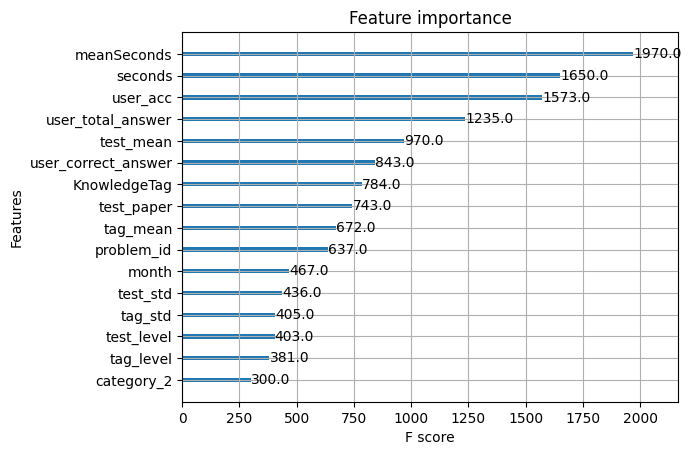

In [82]:
preds = model.predict_proba(valid[FEATS])[:, 1]
auc = roc_auc_score(y_valid, preds)
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))

print(f"VALID AUC : {auc} ACC : {acc}\n")

# feature 중요도 출력
fscore = model.get_booster().get_fscore()
print(sorted(fscore, key=lambda x: x[1]))

plot_importance(model)

## 5. Inference

In [ ]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path, dtype=dtype, parse_dates=['Timestamp'])

# FEATURE ENGINEERING
test_df.sort_values(['userID','Timestamp'], inplace=True)
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [ ]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [ ]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "LGBM2_submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/LGBM2_submission.csv


###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

